In [1]:
#Imports
import keras #code only works with this import!?
import os
import glob
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
#import timm
from sklearn.model_selection import train_test_split
import json
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
from segmentation_models_pytorch import Unet
from tqdm import tqdm
from PIL import Image
import copy
import random  # For random sampling

seed = 42
random.seed(seed)
np.random.seed(seed)

#0. Set user
User="Andrey" #Set to Mark if you are Mark XD
print(User)

c:\Users\9andy\miniconda3\envs\IBT_Hiwi_Zebrafish_new\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\9andy\miniconda3\envs\IBT_Hiwi_Zebrafish_new\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Die angegebene Prozedur wurde nicht gefunden'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Andrey


In [2]:
#Set Parameters Mark

#1. Set parameters for data loading
if User=="Mark":
    
    load_with_split = True #Load data with split or without split use the exel file
    excel_path = "Df_Zebrafish_with_splits.xlsx" #change if Load with split == True

    #Df_Zebrafish_with_splits.xlsx
    
    images_folder = "C:/Users/ma405l/Documents/Heidelberg_Schweregrad/Full_data/Raw_data_full_train"
    masks_folder = "C:/Users/ma405l/Documents/Heidelberg_Schweregrad/Full_data/Masked_images"
    #2. Set parameters for data processing
    target_size=(256,256)	#Size of the images for training
    num_classes = 4

    #3. Train, Val, Test Split
    skip_train = True
    train_size = 0.6
    val_size = 0.2
    test_size = 0.2
    label_name = "Curved"

    #4. Balance datasets
    balance_train = True
    balance_val = False
    balance_test = False

    Model_type = "CNN"

    # Segmentation
    Model_seg = False
    num_epochs_seg = 1
    criterion_seg = torch.nn.BCEWithLogitsLoss()
    seg_directory = "Models/Segmentation"
    seg_train = False

    # HP Tuning
    hp_tuning = True
    hp_dense_layer = [512]
    hp_lr = [2e-4]

    #Use trained model for mask segmentation of images
    use_seg_model = False
    trained_seg_model = f"{seg_directory}/Segmentation/seg_model.pth"

    #5 Transformer. Augmentation parameters
    trans_rotation_range = 45
    trans_width_shift_range = 0.2
    trans_height_shift_range = 0.2
    trans_zoom_range = 0.1
    trans_horizontal_flip  = False
    trans_fill_mode="nearest"

    #6 Transformer. Training parameters
    trans_learning_rate = 0.00008 # Define learing rate
    trans_num_epochs = 1 # Define the number of epochs

    #7 Transformer. Save parameters
    trans_log_directory = f"Models/Transformer"
    trans_model_name = "trans_model.pth"
    trans_metrics_name = "trans_metrics.txt"

    #5 CNN. Augmentation parameters
    cnn_rotation_range = 45
    cnn_width_shift_range = 0.2
    cnn_height_shift_range = 0.2
    cnn_zoom_range = 0.1
    cnn_horizontal_flip  = False
    cnn_fill_mode="nearest"

    #6 CNN. Training parameters
    
    train_from_scratch = False #Train from scratch (vgg_16) or use pre-trained model (already trained)
    
    cnn_learning_rate = 0.001
    cnn_loss = 'crossentropy'
    cnn_num_epochs = 5
    cnn_num_epochs_pre = 5
    dense_layer = 512
    dropout = 0.3

    #7 CNN. Save parameters
    cnn_log_directory = "Models/CNN"
    cnn_model_name = "vgg_16_model.keras"
    cnn_metrics_name = "vgg_16_metrics.json"


In [83]:
#Set Parameters Andrey
#0. Set user
if User=="Andrey":
    
    load_with_split = True #Load data with split or without split use the exel file
    
    excel_path = "C:/Local_Docs/Uni/Hiwi_IBT/Zebra_Fish/Df_Zebrafish_with_splits_AT.xlsx" #change if Load with split == True
    images_folder = "C:/Local_Docs/Uni/Hiwi_IBT/Zebra_Fish/Zebra_fish_data/Raw_data_full_train"
    masks_folder = "C:/Local_Docs/Uni/Hiwi_IBT/Zebra_Fish/Zebra_fish_data/Raw_data_full_masks"

    #2. Set parameters for data processing
    target_size=(256,256)	#Size of the images for training
    num_classes = 4

    #3. Train, Val, Test Split
    train_size = 0.6
    val_size = 0.2
    test_size = 0.2
    label_name = "Curved"

    #4. Balance datasets
    balance_train = True
    balance_val = False
    balance_test = False


    # Segmentation
    Model_seg = False
    num_epochs_seg = 1
    criterion_seg = torch.nn.BCEWithLogitsLoss()
    seg_directory = "C:/Local_Docs/Uni/Hiwi_IBT/Zebra_Fish/Models"
    seg_train = False

    # HP Tuning
    hp_tuning = False
    hp_dense_layer = [512]
    hp_lr = [2e-4]

    #Use trained model for mask segmentation of images
    use_seg_model = True
    trained_seg_model = f"{seg_directory}/segmentation_model.pth"

    #Select Model for classification
    Model_type = "CNN"
    Train_CNN = False
    #5 Transformer. Augmentation parameters
    trans_rotation_range = 45
    trans_width_shift_range = 0.2
    trans_height_shift_range = 0.2
    trans_zoom_range = 0.1
    trans_horizontal_flip  = False
    trans_fill_mode="nearest"

    #6 Transformer. Training parameters
    trans_learning_rate = 0.00008 # Define learing rate
    trans_num_epochs = 1 # Define the number of epochs

    #7 Transformer. Save parameters
    trans_log_directory = f"{seg_directory}/Transformer"
    trans_model_name = "trans_model.pth"
    trans_metrics_name = "trans_metrics.txt"

    #5 CNN. Augmentation parameters
    
    cnn_rotation_range = 45
    cnn_width_shift_range = 0.2
    cnn_height_shift_range = 0.2
    cnn_zoom_range = 0.1
    cnn_horizontal_flip  = False
    cnn_fill_mode="nearest"

    #6 CNN. Training parameters
    cnn_learning_rate = 0.001
    cnn_loss = 'crossentropy'
    cnn_num_epochs = 5
    cnn_num_epochs_pre = 1
    dense_layer = 512
    dropout = 0.3

    #7 CNN. Save parameters
    train_from_scratch = False
    trained_model_name = "test_model.keras"
    cnn_log_directory = f"{seg_directory}/CNN"
    cnn_model_name = "test_model.keras"
    cnn_metrics_name = "vgg_16_metrics.json"
    
    #8 Evaluate Models
    load_directory = f"{seg_directory}/CNN"
    load_model_name = "test_model.keras"

In [4]:
#1) Match the images and masks to the exel data. 
# Create Df with the following columns: Image, Mask Path, Sample, Fish_Num, Edema, Curved, Masked Image
if load_with_split==False:
    def process_fish_data(excel_path, images_folder, masks_folder):
        # Read the Excel file
        df = pd.read_excel(excel_path, dtype={'Sample': str, 'Fish_Num': int, 'Edema': str, 'Curved': str})

        # Convert Fish_Num to two-digit format (01, 02, ...)
        df['Fish_Num'] = df['Fish_Num'].apply(lambda x: f"{x:02d}")

        # Store results
        results = []

        for _, row in df.iterrows():
            sample = row['Sample']
            fish_num = row['Fish_Num']
            edema = row['Edema']
            curved = row['Curved']

            # Find the image
            image_pattern = os.path.join(images_folder, f"*pr_{sample}-{fish_num}*.jpg")
            image_files = glob.glob(image_pattern)

            # Find the mask
            mask_pattern = os.path.join(masks_folder, f"*pr_{sample}-{fish_num}*_mask.jpg")
            mask_files = glob.glob(mask_pattern)

            # Ensure exactly one match
            if len(image_files) != 1 or len(mask_files) != 1:
                print(f"Skipping Sample {sample}, Fish {fish_num}: Image or mask missing/multiple found.")
                continue

            image_path = image_files[0]
            mask_path = mask_files[0]

            # Load image and mask
            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if image is None or mask is None:
                print(f"Skipping {image_path} or {mask_path}: Unable to read file.")
                continue

            # Apply the mask: Everything outside the mask becomes black
            masked_image = cv2.bitwise_and(image, image, mask=mask)

            # Store in results list
            results.append([image_path, mask_path, sample, fish_num, edema, curved, masked_image])

        # Convert to DataFrame
        columns = ['Images', 'Masks', 'Sample', 'Fish_Num', 'Edema', 'Curved', 'Masked Images']
        result_df = pd.DataFrame(results, columns=columns)

        return result_df

    df_result = process_fish_data(excel_path, images_folder, masks_folder)
    #Delete Rows with NAW
    df_result = df_result[df_result[label_name] != "NAW"]
    # Convert label to integers
    df_result["Curved"] = df_result["Curved"].astype(int) 


In [5]:
#Load the df frame directly from the excel file with split
if load_with_split==True:
    def load_and_recreate_masked_images(excel_path):
        # Load the Excel file
        df = pd.read_excel(excel_path, dtype={'Sample': str, 'Fish_Num': str, 'Edema': str, 'Curved': str})
        
        # Ensure Fish_Num is two-digit format
        df['Fish_Num'] = df['Fish_Num'].apply(lambda x: f"{int(x):02d}")

        # Placeholder for the masked images
        masked_images = []

        for _, row in df.iterrows():
            image_path = row['Images']
            mask_path = row['Masks']

            # Load image and mask
            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if image is None or mask is None:
                print(f"Skipping {image_path} or {mask_path}: Unable to read file.")
                masked_images.append(None)
                continue

            # Apply the mask: Everything outside the mask becomes black
            masked_image = cv2.bitwise_and(image, image, mask=mask)
            masked_images.append(masked_image)

        # Add the "Masked Images" column back to the DataFrame
        df['Masked Images'] = masked_images

        return df

    # Load the data and recreate masked images
    df_result = load_and_recreate_masked_images(excel_path)


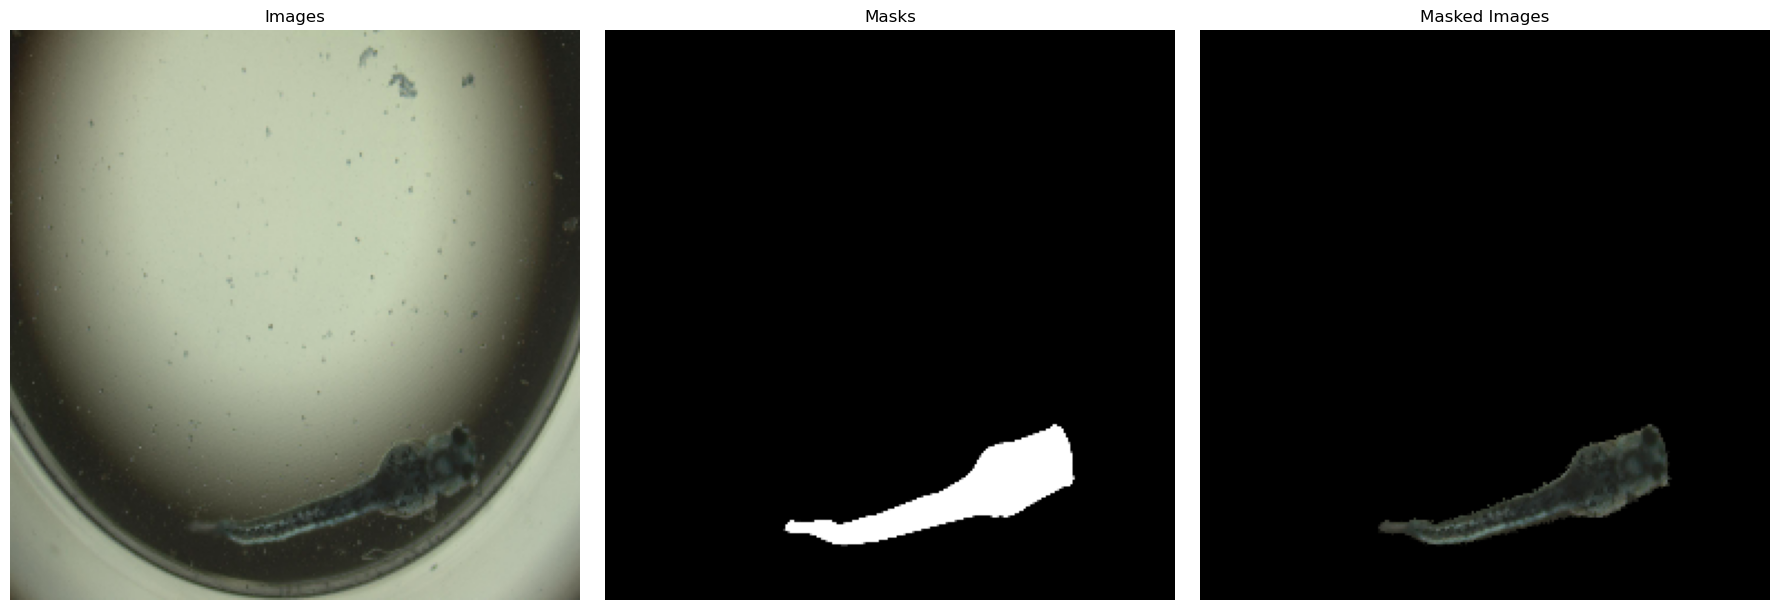

In [6]:
#Define Display Function
def display_images(df, index, col1, col2, col3, target_size=(256, 256)):
    """
    Displays three images side by side from a DataFrame, given their column names.
    
    Args:
    - df: DataFrame containing image paths or preloaded images.
    - index: Index of the row to display.
    - col1, col2, col3: Column names containing the images.
    - target_size: Tuple specifying the target size for resizing.
    """
    def load_and_resize(image_data, target_size):
        """Helper function to load and resize an image or mask."""
        if isinstance(image_data, str):  # If it's a file path
            img = cv2.imread(image_data, cv2.IMREAD_UNCHANGED)
            if img is None:
                raise ValueError(f"Error loading image: {image_data}")
        elif isinstance(image_data, np.ndarray):  # Already an image
            img = image_data
        else:
            raise ValueError("Unsupported image format.")

        return cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)

    # Load and resize images/masks
    img1 = load_and_resize(df.at[index, col1], target_size)
    img2 = load_and_resize(df.at[index, col2], target_size)
    img3 = load_and_resize(df.at[index, col3], target_size)

    # Plot images side by side
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(img1, cmap="gray" if len(img1.shape) == 2 else None)
    axes[0].set_title(col1)
    axes[0].axis("off")

    axes[1].imshow(img2, cmap="gray" if len(img2.shape) == 2 else None)
    axes[1].set_title(col2)
    axes[1].axis("off")

    axes[2].imshow(img3, cmap="gray" if len(img3.shape) == 2 else None)
    axes[2].set_title(col3)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

display_images(df_result, index=3, col1="Images", col2="Masks", col3='Masked Images', target_size=target_size)

In [7]:
#2) Preprocess masked images.
def preprocess_masked_images(df, target_size):
    processed_images = []
    rows_to_delete = []  # Store indices of black images

    for i, row in df.copy().iterrows():  # Iterate over a copy to prevent index shifting
        masked_image = row['Masked Images']

        # Step 1: Convert to grayscale and find non-black pixels
        gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
        coords = cv2.findNonZero(gray)

        if coords is None:  # Image is fully black
            print(f"Deleting row {i} from DataFrame because image was fully black.")
            rows_to_delete.append(row.name)  # Use row.name (original index) instead of i
            continue

        # Step 2: Crop to bounding box
        x, y, w, h = cv2.boundingRect(coords)
        cropped_image = masked_image[y:y+h, x:x+w]

        # Step 3: Pad to square size
        height, width = cropped_image.shape[:2]
        max_dim = max(height, width)
        pad_top = (max_dim - height) // 2
        pad_bottom = max_dim - height - pad_top
        pad_left = (max_dim - width) // 2
        pad_right = max_dim - width - pad_left

        padded_image = cv2.copyMakeBorder(
            cropped_image, pad_top, pad_bottom, pad_left, pad_right,
            cv2.BORDER_CONSTANT, value=[0, 0, 0]
        )

        # Step 4: Resize
        resized_image = cv2.resize(padded_image, target_size, interpolation=cv2.INTER_LINEAR)
        processed_images.append(resized_image)

    # **Drop rows after looping to avoid index shifting**
    df = df.drop(index=rows_to_delete).reset_index(drop=True)
    
    # Update DataFrame
    df['Processed Masked Images'] = processed_images
    return df

#Preprocess masked images
df_result = preprocess_masked_images(df_result, target_size)

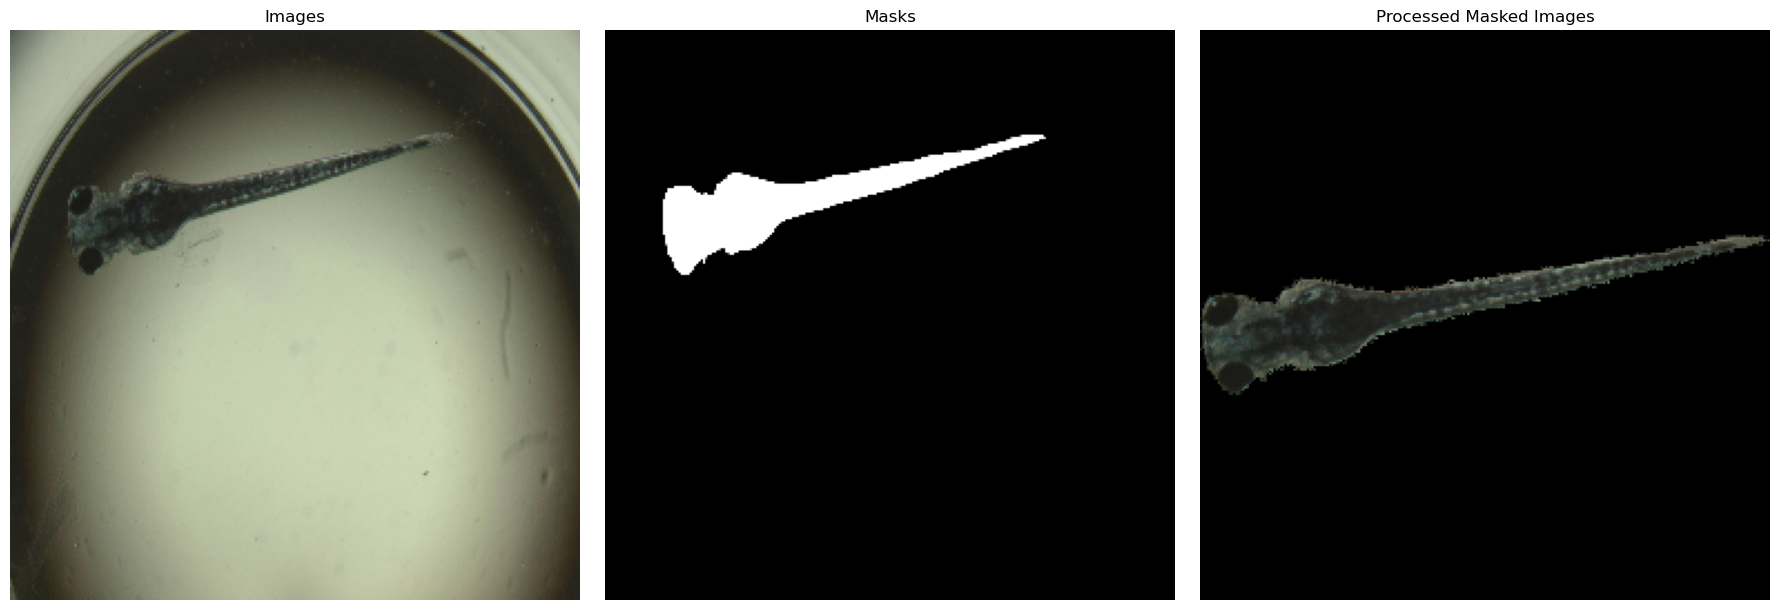

In [8]:
display_images(df_result, index=788, col1="Images", col2="Masks", col3='Processed Masked Images', target_size=target_size) 


In [9]:
#Prepare train val test split for seg model
if Model_seg:
    
    # Load images and masks from filenames
    images_seg = [cv2.imread(file) for file in df_result["Images"]]
    masks_seg = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in df_result["Masks"]]

    # Resize images and masks to target size
    images_seg = [cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR) for image in images_seg]
    masks_seg = [cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST) for mask in masks_seg]

    # Normalize mean and std
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    #Load splits directly from the df frame
    if load_with_split:

        # Filter images and masks based on "split_by_curve"
        images_train = [img for img, split in zip(images_seg, df_result["split_by_curve"]) if split == 0]
        masks_train = [mask for mask, split in zip(masks_seg, df_result["split_by_curve"]) if split == 0]

        images_val = [img for img, split in zip(images_seg, df_result["split_by_curve"]) if split == 1]
        masks_val = [mask for mask, split in zip(masks_seg, df_result["split_by_curve"]) if split == 1]

        images_test = [img for img, split in zip(images_seg, df_result["split_by_curve"]) if split == 2]
        masks_test = [mask for mask, split in zip(masks_seg, df_result["split_by_curve"]) if split == 2]

    #Create a new train val test split form seed
    else:
        # Split the data into training and testing sets
        images_train, images_temp, masks_train, masks_temp = train_test_split(
            images_seg, masks_seg, test_size=(val_size + test_size), random_state=42
        )
        images_val, images_test, masks_val, masks_test = train_test_split(
            images_temp, masks_temp, test_size=(test_size / (val_size + test_size)), random_state=42
        )


    # Normalize the images
    
    images_train = [(image / 255.0 - mean) / std for image in images_train]
    images_val = [(image / 255.0 - mean) / std for image in images_val]
    images_test_copy = copy.deepcopy(images_test)
    images_test = [(image / 255.0 - mean) / std for image in images_test]



In [10]:
#def iop metric
def calculate_iou(pred, target, threshold=120/255.):
        pred = (pred > threshold).float()
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum()
        if union == 0:
            return 1.0
        else:
            return intersection / union

#define segment_fish function
def segment_fish(image, model):
    """
    Segment fish from the image using a pre-trained Unet model.
    
    Parameters:
        image (PIL.Image): The input image.
        
    Returns:
        PIL.Image: The segmented image with fish highlighted.
    """
    # Transform the image
    #image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    image_tensor = image
    
    with torch.no_grad():
        # Get predictions from the model
        prediction = model(image_tensor)
    
    # Get the mask
    mask = prediction.squeeze().cpu().numpy()
    # Convert the mask to a confidence map
    confidence_map = (mask - mask.min()) / (mask.max() - mask.min()) * 255
    confidence_map = confidence_map.astype(np.uint8)
    
    # Convert the confidence map to a binary mask
    binary_mask = (confidence_map > 81).astype(np.uint8) * 255
    
    # Convert the binary mask to a PIL image
    segmented_image = Image.fromarray(binary_mask)
    # Find the largest connected component in the binary mask
    num_labels, labels_im = cv2.connectedComponents(binary_mask)

    # Find the largest component
    largest_component = 1 + np.argmax(np.bincount(labels_im.flat)[1:])

    # Create a mask for the largest component
    largest_component_mask = (labels_im == largest_component).astype(np.uint8) * 255

    # Convert the largest component mask to a PIL image
    segmented_image = Image.fromarray(largest_component_mask)
    
    return segmented_image, confidence_map

In [11]:
#train seg model
if Model_seg == True:

    model = Unet(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    if (os.path.exists(f"{seg_directory}/segmentation_model.pth")and not seg_train):
        model.load_state_dict(torch.load(f"{seg_directory}/segmentation_model.pth"))
        print(f"Model loaded from {seg_directory}/segmentation_model.pth")
    else:
        # Training code here

        loss_history = []
        train_iou_history = []
        val_iou_history = []

        running_val_iou = 0.0
        batch_size = 16
        for epoch in range(num_epochs_seg):
            running_loss = 0.0
            running_train_iou = 0.0
            for i in range(0, len(images_train) , batch_size): #len(images_train)
                batch_images = images_train[i:i + batch_size]
                batch_masks = masks_train[i:i + batch_size]

                # Convert images and masks to torch tensors
                batch_images = np.array(batch_images)
                batch_masks = np.array(batch_masks)
                batch_images = torch.tensor(batch_images, dtype=torch.float32).permute(0, 3, 1, 2)
                batch_masks = torch.tensor(batch_masks, dtype=torch.float32).unsqueeze(1)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(batch_images)

                loss = criterion_seg(outputs, batch_masks) * (1. + 5. * torch.mean((outputs < 0).float()))

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                train_iou = calculate_iou(outputs, batch_masks)
                running_train_iou += train_iou.item()

                print(f"Batch {i // batch_size + 1}/{len(images_train) // batch_size + 1}, Loss: {loss.item():.4f}, Train IoU: {train_iou:.4f}")

            epoch_loss = running_loss / len(images_train)
            epoch_train_iou = running_train_iou / len(images_train)
            loss_history.append(epoch_loss)
            train_iou_history.append(epoch_train_iou)

            # Calculate IoU on validation set
            model.eval()
            with torch.no_grad():
                val_iou = 0.0
                for val_images, val_masks in zip(images_val, masks_val):
                    val_images = torch.tensor(val_images, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
                    val_masks = torch.tensor(val_masks, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
                    val_outputs = model(val_images)
                    val_iou += calculate_iou(val_outputs, val_masks).item()
                epoch_val_iou = val_iou / len(images_val)
                val_iou_history.append(epoch_val_iou)
            model.train()

            print(f"Epoch [{epoch+1}/{num_epochs_seg}], Loss: {epoch_loss:.4f}, Train IoU: {epoch_train_iou:.4f}, Val IoU: {epoch_val_iou:.4f}")

        torch.save(model.state_dict(), f"{seg_directory}/segmentation_model.pth")
        print(f"Model saved to {seg_directory}")
        print("Finished Training")

        # Plot the loss and IoU history per batch
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(loss_history) + 1), loss_history, label='Training Loss')
        plt.plot(range(1, len(train_iou_history) + 1), train_iou_history, label='Training IoU')
        plt.xlabel('Batch')
        plt.ylabel('Value')
        plt.title('Training Loss and IoU Over Batches')
        plt.legend()
        plt.show()

    # Evaluate the model on the test dataset
    model.eval()
    test_iou = 0.0
    with torch.no_grad():
        for test_image, test_mask in zip(images_test, masks_test):
            test_image = torch.tensor(test_image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
            test_mask = torch.tensor(test_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            test_output = model(test_image)
            test_iou += calculate_iou(test_output, test_mask).item()

    average_test_iou = test_iou / len(images_test)
    print(f"Average Test IoU: {average_test_iou:.4f}")
    # Segment and display some results
    fig, axes = plt.subplots(5, 5, figsize=(30, 30))
    # Define the indices before the for loop
    indices = np.random.choice(len(images_test), 5, replace=False)

    for i, idx in enumerate(indices):  # Display first 5 test images

        #original_image = images_test[idx].transpose(2, 0, 1)
        input_image = torch.tensor(images_test[idx], dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
        original_image = images_test_copy[idx]
        #original_image = images_test[idx]
        segmented_image, confidence_map = segment_fish(input_image, model)
        original_mask = masks_test[idx]

        # Plot the original image
        axes[0, i].imshow(original_image)
        axes[0, i].set_title(f"Original Image {i+1}")
        axes[0, i].axis("off")

        # Plot the original mask
        axes[1, i].imshow(original_mask, cmap='gray')
        axes[1, i].set_title(f"Original Mask {i+1}")
        axes[1, i].axis("off")

        # Plot the confidence map with a colorbar
        cax = axes[2, i].imshow(confidence_map, cmap='gray')
        axes[2, i].set_title(f"Confidence Map {i+1}")
        axes[2, i].axis("off")
        fig.colorbar(cax, ax=axes[2, i], orientation='vertical')

        # Plot the binary segmentation
        axes[3, i].imshow(segmented_image, cmap='gray')
        axes[3, i].set_title(f"Segmented Image {i+1}")
        axes[3, i].axis("off")

        # Apply the mask to the original image and plot
        segmented_image_rgb = np.stack([np.array(segmented_image)]*3, axis=-1)
        masked_image = np.array(original_image) * (segmented_image_rgb > 35)
        axes[4, i].imshow(masked_image)
        axes[4, i].set_title(f"Masked Image {i+1}")
        axes[4, i].axis("off")

    plt.tight_layout(pad=3.0)
    plt.show()


In [12]:
# Apply the segmentation model to the images and create Segmented Masks and Confidence Maps columns
if use_seg_model:
    
    # Load model state
    loaded_model = Unet(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=1)
    if os.path.exists(f"{seg_directory}/segmentation_model.pth"):
        loaded_model.load_state_dict(torch.load(f"{seg_directory}/segmentation_model.pth", map_location=torch.device('cpu')))
        loaded_model.eval()  # Set model to evaluation mode
        print(f"Model loaded from {seg_directory}/segmentation_model.pth")
        
        # Define preprocessing parameters
    mean = np.array([0.485, 0.456, 0.406])  # Normalization mean
    std = np.array([0.229, 0.224, 0.225])  # Normalization std

    # Initialize a new list to store the confidence maps
    confidence_maps = []
    segmented_masks = []

    for idx, row in df_result.iterrows():
        img_path = row["Images"]

        # Load image
        original_image = cv2.imread(img_path)  # Load raw image
        #original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Resize image
        original_image = cv2.resize(original_image, target_size, interpolation=cv2.INTER_LINEAR)

        # Normalize image
        processed_image = (original_image / 255.0 - mean) / std

        # Convert to PyTorch tensor (C, H, W) format
        input_image = torch.tensor(processed_image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

        # Get segmentation result from segment_fish function
        segmented_mask, confidence_map = segment_fish(input_image, loaded_model)

        # Convert the PIL image to a NumPy array
        segmented_mask_array = np.array(segmented_mask)
        
        # Append the confidence map to the list
        confidence_maps.append(confidence_map)
        segmented_masks.append(segmented_mask_array)

    # Add the confidence maps and masks as a new column in the DataFrame
    df_result["Confidence Maps"] = confidence_maps    
    df_result["Segmented Masks"] = segmented_masks

Model loaded from C:/Local_Docs/Uni/Hiwi_IBT/Zebra_Fish/Models/segmentation_model.pth


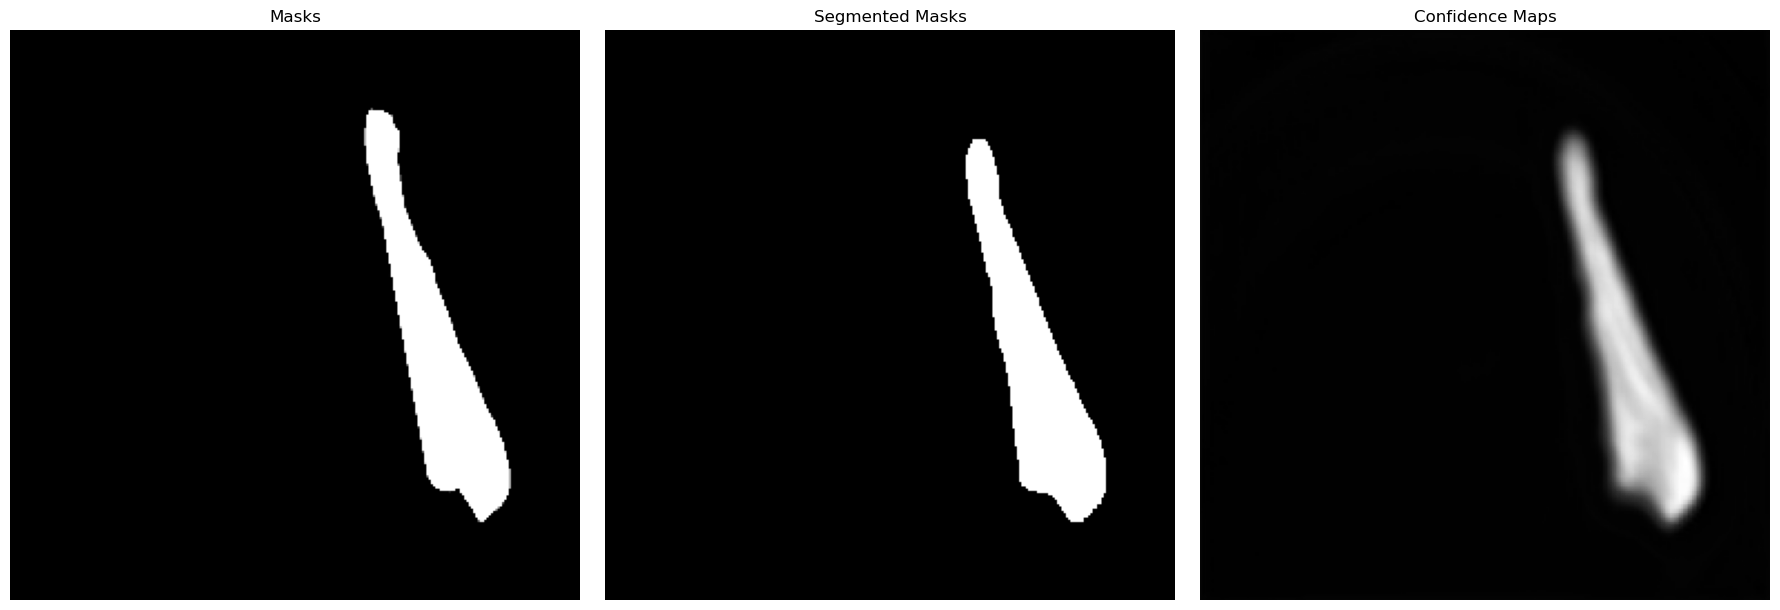

In [15]:
display_images(df_result, index=56, col1="Masks", col2="Segmented Masks", col3='Confidence Maps', target_size=target_size) 

In [ ]:
#Floodfill the holes in segmented masks
def fill_holes(mask):
    """
    Fill all holes in a binary mask (0-1) by flood filling from the background.
    Tries top-left corner first, falls back to bottom-right if needed.
    """
    mask = (mask > 0).astype(np.uint8)  # Ensure the mask is uint8 (0-1 range)
    h, w = mask.shape

    flood_filled = mask.copy()
    mask_ff = np.zeros((h + 2, w + 2), np.uint8)

    # Determine a background seed point (top-left or bottom-right)
    if mask[0, 0] == 0:
        seed = (0, 0)
    elif mask[h - 1, w - 1] == 0:
        seed = (w - 1, h - 1)
    else:
        return mask  # Return the original mask if no safe corner found

    # Perform flood fill
    cv2.floodFill(flood_filled, mask_ff, seedPoint=seed, newVal=1)

    # Invert the flood fill result (this now represents the "holes")
    flood_filled_inv = 1-flood_filled
        
    # Combine the original mask with the holes to a new mask: result (0-1 range)
    filled_mask = mask | flood_filled_inv
    
    # Optional: Debugging - print original mask with hole and filled mask
    """if np.count_nonzero(flood_filled_inv)> 0:
        # Assume mask1 and mask2 are numpy arrays (binary masks)
        plt.figure(figsize=(10, 5))  # Width, height in inches

        # Display mask 1
        plt.subplot(1, 2, 1)  # (rows, columns, index)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Display mask 2
        plt.subplot(1, 2, 2)
        plt.imshow(filled_mask, cmap='gray')
        plt.title("Filled Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()"""

    # Scale to 0-255 before returning
    return (filled_mask * 255).astype(np.uint8)



df_result["Filled Masks"] = df_result["Segmented Masks"].apply(fill_holes)


In [ ]:
#Grow mask with morphology filter
def grow_mask(mask, iterations=1, kernel_size=3):
    """
    Dilate the mask to grow the region by a number of iterations.

    Args:
    - mask: binary mask (numpy array with 0 and 1 or 0 and 255)
    - iterations: how many times to apply dilation
    - kernel_size: size of the structuring element

    Returns:
    - grown mask (same shape)
    """
    # Ensure binary with values 0 and 1
    mask = (mask > 0).astype(np.uint8)

    # Create a structuring element (you can also try cv2.MORPH_RECT or MORPH_CROSS)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

    # Apply dilation
    dilated = cv2.dilate(mask, kernel, iterations=iterations)

    return dilated*255

#Apply the function to the DataFrame (1 or 3 interations)
df_result["Grown Masks"] = df_result["Filled Masks"].apply(grow_mask, iterations=3, kernel_size=3)

In [66]:
#Compute metrics to evaluate the Segmentation
from scipy.spatial.distance import directed_hausdorff

def compute_segmentation_metrics(df, col_pred, col_true, threshold=0, target_size=(256, 256)):
    total_dice = 0
    total_iou = 0
    total_precision = 0
    total_recall = 0
    total_hausdorff = 0
    valid_hausdorff_count = 0
    num_samples = 0

    def load_and_resize(image_data, target_size):
        if isinstance(image_data, str):
            img = cv2.imread(image_data, cv2.IMREAD_UNCHANGED)
            if img is None:
                raise ValueError(f"Error loading image: {image_data}")
        elif isinstance(image_data, np.ndarray):
            img = image_data
        else:
            raise ValueError("Unsupported image format.")
        return cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)

    for pred, true in zip(df[col_pred], df[col_true]):
        pred_img = load_and_resize(pred, target_size)
        true_img = load_and_resize(true, target_size)

        pred_mask = (pred_img > threshold).astype(np.uint8)
        true_mask = (true_img > 0).astype(np.uint8)

        pred_flat = pred_mask.flatten()
        true_flat = true_mask.flatten()

        intersection = np.sum(pred_flat * true_flat)
        union = np.sum(np.logical_or(pred_flat, true_flat))

        # Dice
        dice = (2. * intersection) / (np.sum(pred_flat) + np.sum(true_flat) + 1e-8)
        total_dice += dice

        # IoU
        iou = intersection / (union + 1e-8)
        total_iou += iou

        # True Positives (TP)
        tp = intersection

        # False Positives (FP): predicted but not in ground truth
        fp = np.sum(pred_flat) - tp

        # False Negatives (FN): missed ground truth
        fn = np.sum(true_flat) - tp

        # Precision
        precision = tp / (tp + fp + 1e-8)
        total_precision += precision

        # Recall
        recall = tp / (tp + fn + 1e-8)
        total_recall += recall

        # Hausdorff Distance
        if np.any(pred_mask) and np.any(true_mask):
            pred_points = np.argwhere(pred_mask)
            true_points = np.argwhere(true_mask)
            hausdorff = max(
                directed_hausdorff(pred_points, true_points)[0],
                directed_hausdorff(true_points, pred_points)[0]
            )
            total_hausdorff += hausdorff
            valid_hausdorff_count += 1

        num_samples += 1

    return {
        'Mean Dice': total_dice / num_samples,
        'Mean IoU': total_iou / num_samples,
        'Mean Precision': total_precision / num_samples,
        'Mean Recall': total_recall / num_samples,
        'Mean Hausdorff': total_hausdorff / (valid_hausdorff_count or 1)  # avoid division by 0
    }
    
    

# Compute metrics only on test data
metrics = compute_segmentation_metrics(
    df_result[df_result['split_by_curve'] == 2],
    col_pred="Grown Masks",
    col_true="Masks",
    threshold=0
)

# Print the results nicely
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

Mean Dice: 0.8223
Mean IoU: 0.7041
Mean Precision: 0.7326
Mean Recall: 0.9513
Mean Hausdorff: 14.7421


In [ ]:
#Apply segmented masks to the images and change columen name of masked images
#Preprocess masked images and create the column "processed_image"
if use_seg_model:
    masked_images = []

    for idx, row in df_result.iterrows():
        img_path = row["Images"]
        #!!!currently the origninal masks are used!!!
        mask = row["Masks"]

        # Load the original image
        original_image = cv2.imread(img_path)  # Load raw image
        
        # Resize image to match mask size
        original_image = cv2.resize(original_image, target_size, interpolation=cv2.INTER_LINEAR)

        # Ensure mask is in correct format
        if isinstance(mask, str):  # If it's a file path
            mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

        elif isinstance(mask, Image.Image):  # If it's a PIL image
            mask = np.array(mask)

        elif isinstance(mask, np.ndarray):
            mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

        # Ensure mask is binary (0 or 255)
        mask = (mask > 0).astype(np.uint8)

        # Convert mask to 3 channels (so it can be applied to RGB image)
        mask_3ch = np.stack([mask] * 3, axis=-1)

        # Apply the mask to the image
        masked_image = original_image * mask_3ch

        # Append result
        masked_images.append(masked_image)

    # Overwrite the "Masked Images" column
    df_result["Masked Images"] = masked_images

    df_result = preprocess_masked_images(df_result, target_size)


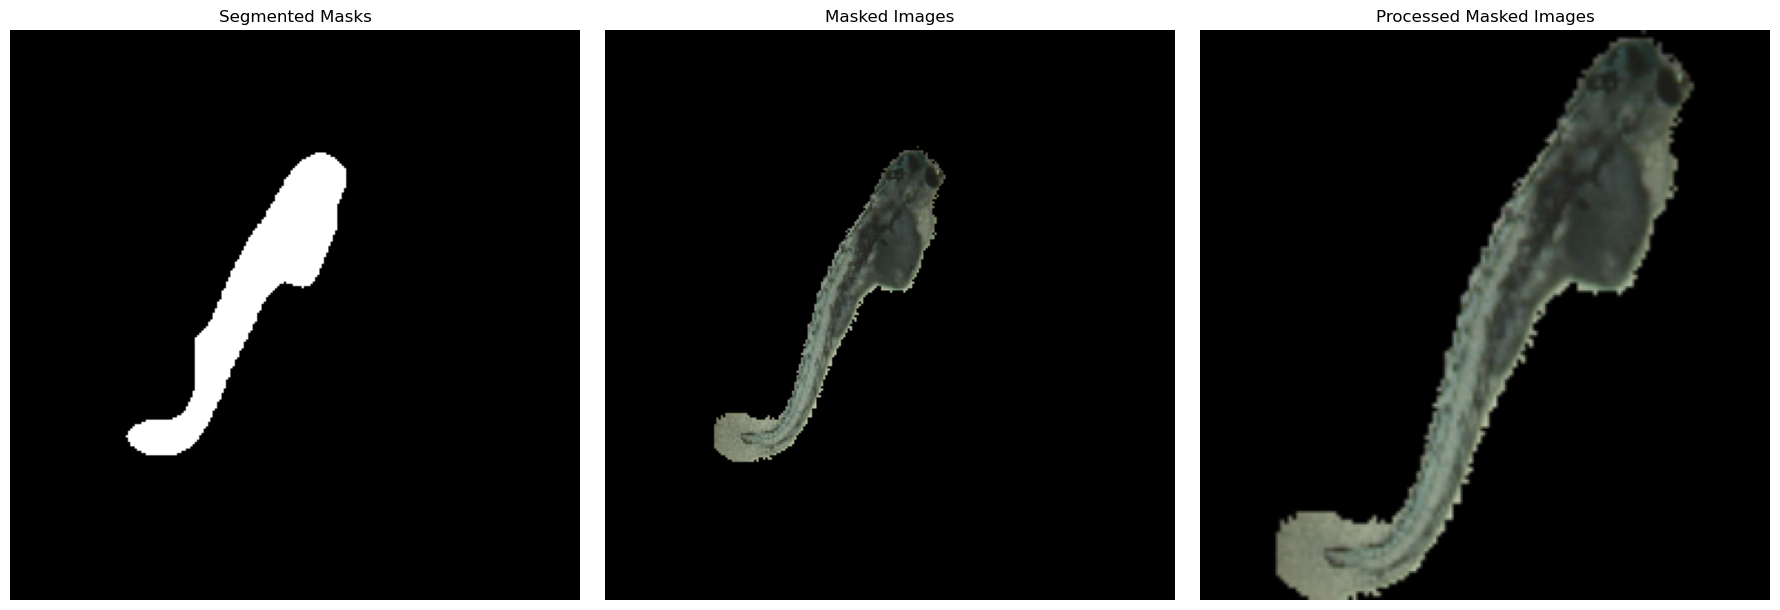

In [ ]:
#Display predicted Mask, Masked image and Processed Masked Image
if use_seg_model:
    display_images(df_result, index=1, col1="Masks", col2="Masked Images", col3='Processed Masked Images', target_size=target_size)


In [136]:
#3) Train, Val, Test Split saved in 3 new DataFrames
if load_with_split and label_name == "Curved":
    
    # Create separate DataFrames based on "split_by_curve"
    df_train = df_result[df_result["split_by_curve"] == 0].reset_index(drop=True)
    df_val = df_result[df_result["split_by_curve"] == 1].reset_index(drop=True)
    df_test = df_result[df_result["split_by_curve"] == 2].reset_index(drop=True)

elif load_with_split and label_name != "Curved":
    
    # Create separate DataFrames based on "split_by_edema"
    df_train = df_result[df_result["split_by_edema"] == 0].reset_index(drop=True)
    df_val = df_result[df_result["split_by_edema"] == 1].reset_index(drop=True)
    df_test = df_result[df_result["split_by_edema"] == 2].reset_index(drop=True)

    
else:
    def split_data(df, train_size=70, val_size=20, test_size=10, label_name="Curved"):
        # Normalize percentages if they don’t sum to 100%
        total = train_size + val_size + test_size
        train_size, val_size, test_size = train_size / total, val_size / total, test_size / total

        # Shuffle data before splitting
        df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

        # Split into train and temp (val + test), stratified by label_name
        df_train, df_temp = train_test_split(df, test_size=(1 - train_size), random_state=seed, stratify=df[label_name])

        # Split temp into val and test, also stratified
        df_val, df_test = train_test_split(df_temp, test_size=(test_size / (test_size + val_size)), 
                                        random_state=seed, stratify=df_temp[label_name])

        return df_train, df_val, df_test

    #apply split_data function to the df_result
    df_train, df_val, df_test = split_data(df_result, train_size, val_size, test_size, label_name)


C:\Users\9andy\AppData\Local\Temp\ipykernel_18812\44143708.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_classes))  # Adjust colormap if more than 10 classes


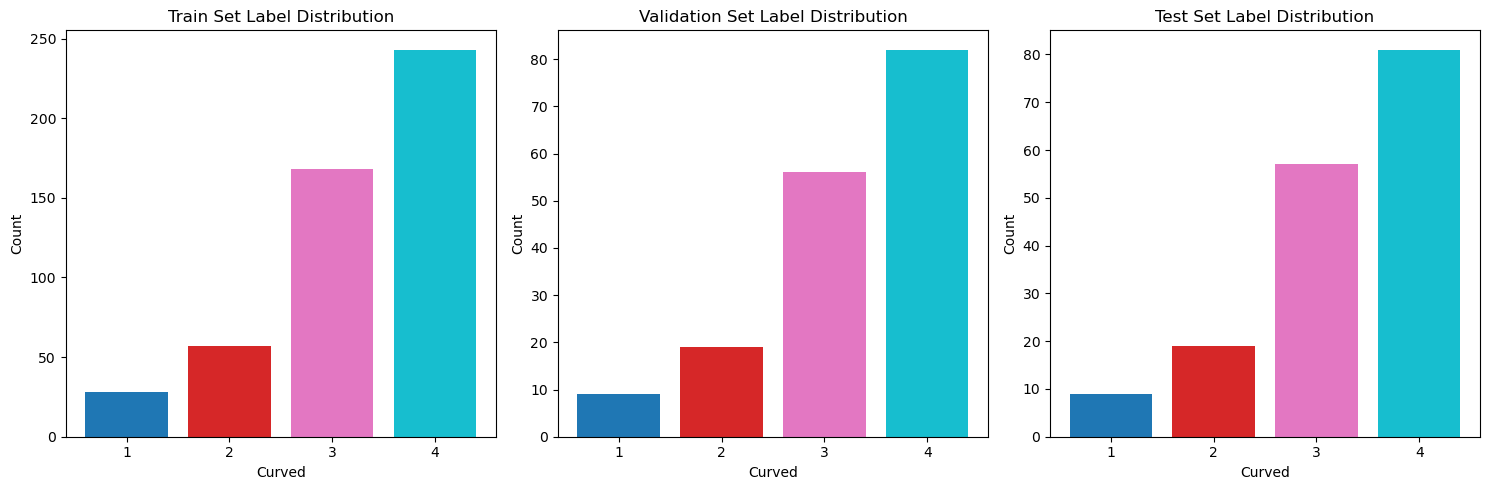

In [137]:
#Display label distribution

def plot_label_distribution(df_train, df_val, df_test, label_name):
    # Get all unique classes across all sets and sort them numerically
    unique_classes = sorted(set(df_train[label_name].unique()) | 
                            set(df_val[label_name].unique()) | 
                            set(df_test[label_name].unique()))
    
    # Generate a color palette based on the number of classes
    colors = plt.cm.get_cmap('tab10', len(unique_classes))  # Adjust colormap if more than 10 classes
    
    # Create a dictionary for consistent color mapping
    color_map = {class_label: colors(i) for i, class_label in enumerate(unique_classes)}

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for ax, df, title in zip(axes, [df_train, df_val, df_test], ["Train", "Validation", "Test"]):
        label_counts = df[label_name].value_counts()

        # Ensure labels are sorted numerically
        sorted_labels = sorted(label_counts.index)

        # Plot the bars using the consistent colors
        ax.bar(sorted_labels, label_counts[sorted_labels].values, 
               color=[color_map[label] for label in sorted_labels])

        ax.set_title(f"{title} Set Label Distribution")
        ax.set_xlabel(label_name)
        ax.set_ylabel("Count")
        ax.set_xticks(sorted_labels)

    plt.tight_layout()
    plt.show()



# Example usage
plot_label_distribution(df_train, df_val, df_test, label_name)

In [138]:
#4) Balance the dataframes

#Augmentation functions
def apply_augmentation(image, augmentation_type):
    if augmentation_type == 'horizontal_flip':
        return cv2.flip(image, 1)
    elif augmentation_type == 'vertical_flip':
        return cv2.flip(image, 0)
    elif augmentation_type == 'both_flip':
        return cv2.flip(image, -1)
    elif augmentation_type == 'zoom_out':
        height, width = image.shape[:2]
        zoom_factor = 0.8  # 20% zoom out
        
        # Resize the image to 80% of its original size (zoom-out)
        resized_image = cv2.resize(image, (int(width * zoom_factor), int(height * zoom_factor)))
        
        # Create a black image of the original size
        padded_image = np.zeros((height, width, 3), dtype=np.uint8)
        
        # Calculate the padding size (difference between original and resized dimensions)
        top = (height - resized_image.shape[0]) // 2
        bottom = height - resized_image.shape[0] - top
        left = (width - resized_image.shape[1]) // 2
        right = width - resized_image.shape[1] - left
        
        # Place the resized image into the black canvas with padding
        padded_image[top:top+resized_image.shape[0], left:left+resized_image.shape[1]] = resized_image
        
        return padded_image
    return image

#Balance the dataframes by counting the most frequent class and augmenting the other classes
def balance_dataframe(df_frame, label_name, augmentations=['horizontal_flip', 'vertical_flip', 'both_flip', 'zoom_out']):
    # 1. Find the most represented class (most frequent class)
    most_frequent_class = df_frame[label_name].mode()[0]
    largest_class_size = (df_frame[label_name] == most_frequent_class).sum()

    # 2. Create a list to store augmented data
    augmented_rows = []

    # 3. Iterate over all the other classes
    for current_class in df_frame[label_name].unique():
        if current_class == most_frequent_class:
            continue  # Skip the most frequent class

        # Calculate the imbalance factor
        current_class_size = (df_frame[label_name] == current_class).sum()
        imbalance_factor = largest_class_size / current_class_size

        # Find the closest augmentation set to apply
        num_augmentations = min(5, round(imbalance_factor)) - 1  # Max 4 augmentations per image

        # Get the rows for the current class
        class_df = df_frame[df_frame[label_name] == current_class]

        # 4. Apply augmentations to each image in the current class
        for _, row in class_df.iterrows():
            original_image = row['Processed Masked Images']  # Image path or image itself

            for i in range(num_augmentations):
                augmented_image = apply_augmentation(original_image, augmentations[i])

                # Copy the row and replace the augmented image
                augmented_row = row.copy()
                augmented_row['Processed Masked Images'] = augmented_image
                augmented_rows.append(augmented_row)

    # 5. Combine the original and augmented data
    augmented_df = pd.DataFrame(augmented_rows)
    balanced_df = pd.concat([df_frame, augmented_df], ignore_index=True)

    return balanced_df

#Toggle to balance train, val and test dataframes
if balance_train==True:
    df_train = balance_dataframe(df_train, label_name)
if balance_val==True:
    df_val = balance_dataframe(df_val, label_name)
if balance_test==True:
    df_test = balance_dataframe(df_test, label_name)    


C:\Users\9andy\AppData\Local\Temp\ipykernel_18812\44143708.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_classes))  # Adjust colormap if more than 10 classes


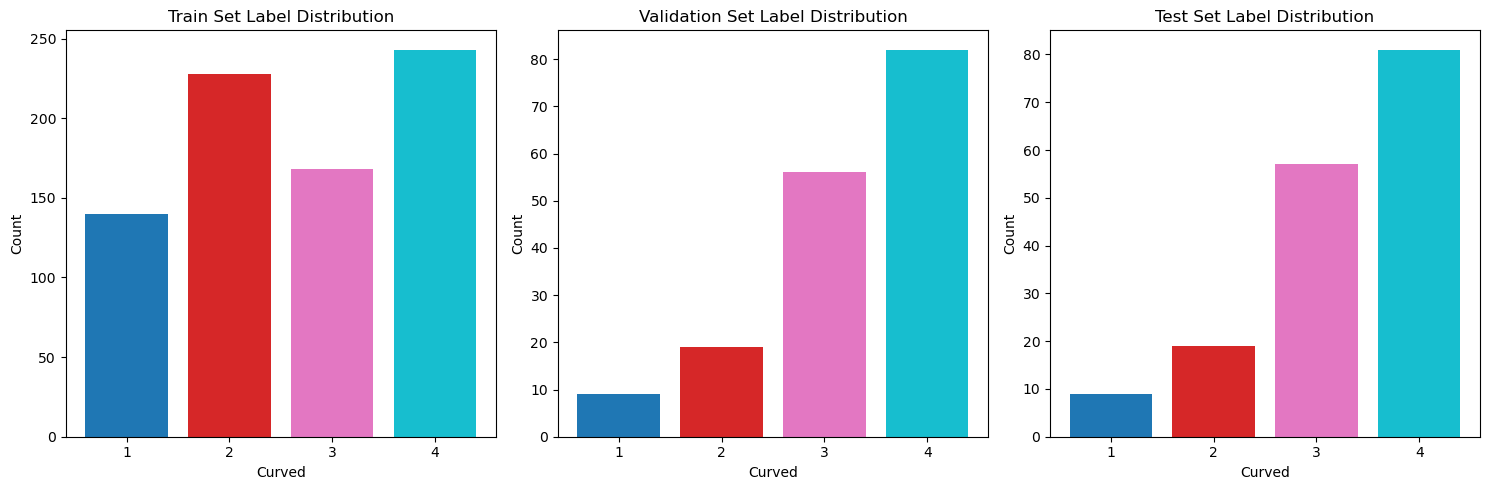

In [139]:
#Display Label Distribution after balancing
plot_label_distribution(df_train, df_val, df_test, label_name)

In [140]:
# Configure the ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=trans_rotation_range,
    width_shift_range=trans_width_shift_range,
    height_shift_range=trans_height_shift_range,
    zoom_range=trans_zoom_range,
    horizontal_flip=trans_horizontal_flip,
    fill_mode=trans_fill_mode,
)

# Function to apply data augmentation to a batch
def apply_data_augmentation(batch_data):
    batch_data_array = np.array(batch_data)
    augmented_batch_data = []
    for image in batch_data_array:
        augmented_image = train_datagen.random_transform(image)
        augmented_batch_data.append(augmented_image)
    return augmented_batch_data


#Create data and Labels from the dataframes
def create_data_and_labels(df_frame, label_name):
    data = []
    labels = []

    for _, row in df_frame.iterrows():
        image = row['Processed Masked Images']
        label = row[label_name]

        data.append(image)
        labels.append(int(label))  # Convert label to integer

    return data, labels

train_data, train_labels = create_data_and_labels(df_train, label_name)
val_data, val_labels = create_data_and_labels(df_val, label_name)
test_data, test_labels = create_data_and_labels(df_test, label_name)


# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(list(zip(train_data, train_labels)), batch_size=25, shuffle=True)
val_loader = DataLoader(list(zip(val_data, val_labels)), batch_size=25, shuffle=True)
test_loader = DataLoader(list(zip(test_data, test_labels)), batch_size=25, shuffle=False)

# Load the pre-trained DeiT model with 224x224 resolution
#trans_model = timm.create_model('deit_small_distilled_patch16_224', pretrained=True)

# Define the optimizer and loss function
#optimizer = Adam(trans_model.parameters(), lr=trans_learning_rate)
criterion = CrossEntropyLoss()

# Lists to track metrics
training_loss_list = []
training_acc_list = []
val_acc_list = []

In [141]:
if Model_type == "Transformer":
    
    from transformers import DeiTForImageClassification, DeiTFeatureExtractor
    # Training loop for Transformer model
    for epoch in range(trans_num_epochs):
        print(f'Epoch {epoch + 1}/{trans_num_epochs}')  # Print the current epoch number
        
        # Load DeiT-Small model and feature extractor
        trans_model = DeiTForImageClassification.from_pretrained("facebook/deit-small-patch16-224")
        feature_extractor = DeiTFeatureExtractor.from_pretrained("facebook/deit-small-patch16-224")

        # Move model to GPU if available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        trans_model.to(device)
        
        # Initialize metrics for training
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        # Training phase
        trans_model.train()  # Set the model to training mode
        for inputs, labels in train_loader:
            inputs = apply_data_augmentation(inputs)  # Apply data augmentation to the input batch
            optimizer.zero_grad()  # Reset gradients from the previous step
            
            # Preprocess inputs and perform forward pass
            batch = feature_extractor(list(inputs), return_tensors="pt", do_normalize=True)
            pixel_values = batch['pixel_values']  # Extract the tensor for the model input

            outputs = trans_model(pixel_values)
            
            # Calculate loss and perform backward pass
            loss = criterion(outputs, labels)
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model weights
            
            # Accumulate loss and accuracy metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        # Calculate average training loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_predictions
        
        # Store training metrics for later analysis
        training_loss_list.append(epoch_loss)
        training_acc_list.append(epoch_accuracy)

        # Validation phase
        trans_model.eval()  # Set the model to evaluation mode
        val_correct_predictions = 0
        val_total_predictions = 0
        
        with torch.no_grad():  # Disable gradient computation for validation
            for inputs, labels in val_loader:
                batch = feature_extractor(list(inputs), return_tensors="pt", do_normalize=True)
                pixel_values = batch['pixel_values']
                outputs = trans_model(pixel_values)
                
                _, predicted = torch.max(outputs, 1)
                val_correct_predictions += (predicted == labels).sum().item()
                val_total_predictions += labels.size(0)
        
        # Calculate validation accuracy for the epoch
        val_accuracy = val_correct_predictions / val_total_predictions

        val_acc_list.append(val_accuracy)


    # Log metrics and test labels

    os.makedirs(trans_log_directory, exist_ok=True)

    # Save the model at the end of training (after the final epoch)
    final_model_path = os.path.join(trans_log_directory, trans_model_name)
    torch.save(trans_model.state_dict(), final_model_path)
    print(f'Model saved to {final_model_path}')

    # Save metrics
    metrics_path = os.path.join(trans_log_directory, trans_metrics_name)
    with open(metrics_path, 'w') as f:
        f.write('Training Loss List:\n')
        f.write(str(training_loss_list) + '\n\n')
        f.write('Training Accuracy List:\n')
        f.write(str(training_acc_list) + '\n\n')
        f.write('Validation Accuracy List:\n')
        f.write(str(val_acc_list) + '\n\n')
        
        
    #compute test accuracy
    trans_model.eval()  # Set the model to evaluation mode
    test_correct_predictions = 0
    test_total_predictions = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in test_loader:
            batch = feature_extractor(list(inputs), return_tensors="pt", do_normalize=True)
            pixel_values = batch['pixel_values']
            outputs = trans_model(pixel_values)
            
            _, predicted = torch.max(outputs, 1)
            test_correct_predictions += (predicted == labels).sum().item()
            test_total_predictions += labels.size(0)

    # Calculate validation accuracy for the epoch
    test_accuracy = test_correct_predictions / test_total_predictions

    print(f'Test Accuracy: {test_accuracy:.2%}')

In [142]:
def generate_grad_cam(model, feature_extractor, input_image, target_layer):
    # Create a model that maps the input image to the activations of the target layer
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(target_layer).output, model.output]
    )

    # Compute the gradient of the top predicted class for the input image
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(tf.expand_dims(input_image, axis=0))
        loss = predictions[:, 0]

    # Compute the gradient of the loss with respect to the output feature map
    grads = tape.gradient(loss, conv_outputs)[0]

    # Compute the guided gradients
    guided_grads = tf.cast(conv_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads

    # Compute the average of the gradients for each feature map
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    # Compute the weighted sum of the feature maps
    cam = tf.reduce_sum(weights * conv_outputs[0], axis=-1)

    # Apply ReLU to the weighted sum to get the final Grad-CAM
    cam = tf.maximum(cam, 0)

    # Normalize the Grad-CAM to the range [0, 1]
    cam = cam / tf.reduce_max(cam)

    return cam.numpy()

def plot_grad_cam(image, grad_cam):
    import matplotlib.pyplot as plt

    # Resize the Grad-CAM to the size of the input image


    grad_cam = np.uint8(255 * grad_cam)
    grad_cam = np.expand_dims(grad_cam, axis=-1)
    grad_cam = np.repeat(grad_cam, 3, axis=-1)
    grad_cam = tf.image.resize(grad_cam, (image.shape[0], image.shape[1])).numpy()

    # Superimpose the Grad-CAM on the input image
    superimposed_image = np.uint8(0.5 * grad_cam + 0.5 * image)

    # Apply color grading to the superimposed image
    superimposed_image = cv2.applyColorMap(superimposed_image, cv2.COLORMAP_VIRIDIS)

    return superimposed_image, grad_cam

# Plot 5 images at once
def plot_multiple_grad_cams(images, grad_cams):
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for i in range(5):
        superimposed_image, grad_cam = plot_grad_cam(images[i], grad_cams[i])
        im = axes[i].imshow(superimposed_image)
        axes[i].set_title(f"Image {i+1}")
        axes[i].axis("off")
        
        # Add colorbar
        cbar = fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
        
    plt.show()


In [143]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
import copy


# Data augmentation function
def preprocess_function(image):
    # Adjust contrast of the image
    image = tf.image.adjust_contrast(image, 1.2)
    return image

train_datagen = ImageDataGenerator(
    rotation_range=cnn_rotation_range,
    width_shift_range=cnn_width_shift_range,
    height_shift_range=cnn_height_shift_range,
    zoom_range=cnn_zoom_range,
    horizontal_flip=cnn_horizontal_flip,
    fill_mode=cnn_fill_mode,
    preprocessing_function=preprocess_function  # Custom preprocessing function
)

# Normalize the data and convert to NumPy arrays
def normalize_images(data):
    # Check if data contains np.arrays, if yes, directly normalize them
    if isinstance(data[0], np.ndarray):
        return np.array(data, dtype=np.float32)
    else:
        return np.array([np.array(image) for image in data], dtype=np.float32) 

X_train = normalize_images(train_data)
X_val = normalize_images(val_data)
X_test = normalize_images(test_data)

# Preprocess input data for VGG16 (standardize based on ImageNet)
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test_copy = copy.deepcopy(X_test)
X_test = preprocess_input(X_test)

# Convert labels to NumPy arrays
y_train = np.array(train_labels) - 1
y_val = np.array(val_labels) - 1
y_test = np.array(test_labels) - 1

y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

if Model_type == "CNN" and hp_tuning == True and skip_train == False:
    

    # Load the pre-trained VGG16 model
    # Include only convolutional base (no fully connected layers) and use the specified input shape
    input_shape = (target_size[0], target_size[1], 3)  # Specify the input shape


    # Define the hyperparameter grid
    param_grid = {
        'dense_layer': hp_dense_layer,
        'learning_rate': hp_lr
    }

    best_val_accuracy = 0
    best_params = None
    best_model = None

    for params in ParameterGrid(param_grid):
        print(f"Training with params: {params}")

        
        vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

        # Freeze all layers in the pre-trained model
        for layer in vgg16.layers:
            layer.trainable = False

        # Add custom classification head
        x = Flatten()(vgg16.output)  # Flatten the feature map into a 1D vector
        x = Dense(params['dense_layer'], activation='relu', kernel_regularizer=l1(0.001))(x)  # Fully connected layer with L1 regularization
        x = Dropout(dropout)(x)  # Dropout to prevent overfitting
        predictions = Dense(num_classes, activation='softmax')(x) # Output layer for binary classification

        # Define the complete model
        model = Model(inputs=vgg16.input, outputs=predictions)

        # Create a training data generator with data augmentation
        train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

        # Compile the model
        model.compile(
            optimizer=Adam(learning_rate=params['learning_rate']),  # Optimizer with specified learning rate
            loss=cnn_loss,  # Binary cross-entropy loss for binary classification
            metrics=['accuracy']  # Track accuracy during training
        )

        # Train the model
        history = model.fit(
            train_generator,  # Use the augmented data generator for training
            epochs=cnn_num_epochs_pre,  # Train for specified epochs
            validation_data=(X_val, y_val),  # Use the validation set for evaluation
        )


        for layer in model.layers:
            layer.trainable = True

        # Define a callback to save the best model based on validation accuracy
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(cnn_log_directory, 'best_model.keras'),
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )

        # Train the model
        history = model.fit(
            train_generator,  # Use the augmented data generator for training
            epochs=cnn_num_epochs,  # Train for specified epochs
            validation_data=(X_val, y_val),  # Use the validation set for evaluation
            callbacks=[checkpoint_callback]  # Include the checkpoint callback
        )

        # Load the best model after training
        best_model_path = os.path.join(cnn_log_directory, 'best_model.keras')
        model = tf.keras.models.load_model(best_model_path)
        print(f"Best model loaded from {best_model_path}")

        # Evaluate the model on the validation set
        val_predictions = model.predict(X_val)
        val_pred_classes = np.argmax(val_predictions, axis=1)
        val_true_classes = np.argmax(y_val, axis=1)
        val_accuracy = accuracy_score(val_true_classes, val_pred_classes)

        print(f"Validation accuracy: {val_accuracy:.4f}")

        # Update the best model if the current one is better
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = params
            best_model = model

    print(f"Best validation accuracy: {best_val_accuracy:.4f}")
    print(f"Best parameters: {best_params}")

    # Evaluate the best model on the test set
    test_predictions = best_model.predict(X_test)
    test_pred_classes = np.argmax(test_predictions, axis=1)
    test_true_classes = np.argmax(y_test, axis=1)
    test_accuracy = accuracy_score(test_true_classes, test_pred_classes)

    print(f"Test accuracy: {test_accuracy:.4f}")


X_train shape: (779, 256, 256, 3), y_train shape: (779, 4)
X_val shape: (166, 256, 256, 3), y_val shape: (166, 4)
X_test shape: (166, 256, 256, 3), y_test shape: (166, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


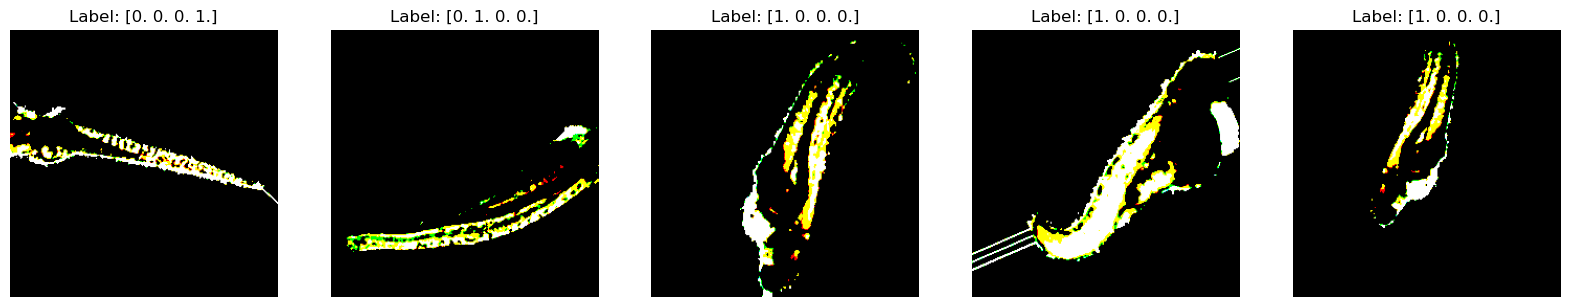

In [144]:
import random
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
import copy

if Model_type == "CNN" and hp_tuning == False:

    # Data augmentation function
    def preprocess_function(image):
        # Adjust contrast of the image
        image = tf.image.adjust_contrast(image, 1.2)
        return image

    train_datagen = ImageDataGenerator(
        rotation_range=cnn_rotation_range,
        width_shift_range=cnn_width_shift_range,
        height_shift_range=cnn_height_shift_range,
        zoom_range=cnn_zoom_range,
        horizontal_flip=cnn_horizontal_flip,
        fill_mode=cnn_fill_mode,
        preprocessing_function=preprocess_function  # Custom preprocessing function
    )

    # Load the pre-trained VGG16 model
    if train_from_scratch and Train_CNN:
        # Include only convolutional base (no fully connected layers) and use the specified input shape
        input_shape = (target_size[0], target_size[1], 3)  # Specify the input shape
        vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

        # Freeze all layers in the pre-trained model
        for layer in vgg16.layers:
            layer.trainable = False


        # Add custom classification head
        x = Flatten()(vgg16.output)  # Flatten the feature map into a 1D vector
        x = Dense(dense_layer, activation='relu', kernel_regularizer=l1(0.001))(x)  # Fully connected layer with L1 regularization
        x = Dropout(dropout)(x)  # Dropout to prevent overfitting
        predictions = Dense(num_classes, activation='softmax')(x) # Output layer for binary classification

        # Define the complete model
        model = Model(inputs=vgg16.input, outputs=predictions)

        # Print a summary of the model
        model.summary()
    elif Train_CNN:
        #Load an already trained model
        trained_model_path= f"{cnn_log_directory}/{trained_model_name}"
        model = tf.keras.models.load_model(trained_model_path)
        

    # Normalize the data and convert to NumPy arrays
    def normalize_images(data):
        # Check if data contains np.arrays, if yes, directly normalize them
        if isinstance(data[0], np.ndarray):
            return np.array(data, dtype=np.float32)
        else:
            return np.array([np.array(image) for image in data], dtype=np.float32) 

    X_train = normalize_images(train_data)
    X_val = normalize_images(val_data)
    X_test = normalize_images(test_data)


    # Preprocess input data for VGG16 (standardize based on ImageNet)
    X_train = preprocess_input(X_train)
    X_val = preprocess_input(X_val)
    X_test_copy = copy.deepcopy(X_test)
    X_test = preprocess_input(X_test)

    # Convert labels to NumPy arrays
    y_train = np.array(train_labels) - 1
    y_val = np.array(val_labels) - 1
    y_test = np.array(test_labels) - 1

    y_train = to_categorical(y_train, num_classes=num_classes)
    y_val = to_categorical(y_val, num_classes=num_classes)
    y_test = to_categorical(y_test, num_classes=num_classes)

    # Verify the shapes
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    # Create a training data generator with data augmentation
    train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

    # Get a batch of images and labels
    images, labels = next(train_generator)

    # Select 5 random indices from the batch
    random_indices = random.sample(range(len(images)), 5)

    # Plot the selected images
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for i, idx in enumerate(random_indices):
        axes[i].imshow(images[idx])
        axes[i].set_title(f"Label: {labels[idx]}")
        axes[i].axis("off")
    plt.show()
    
    if Train_CNN == True:
        
        # Compile the model    
        model.compile(
            optimizer=Adam(learning_rate=cnn_learning_rate),  # Optimizer with specified learning rate
            loss=cnn_loss,  # Binary cross-entropy loss for binary classification
            metrics=['accuracy']  # Track accuracy during training
        )

        # Define a callback to save the best model based on validation accuracy
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(cnn_log_directory, 'best_model.keras'),
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )
        # Train the model
        history = model.fit(
            train_generator,  # Use the augmented data generator for training
            epochs=cnn_num_epochs,  # Train for specified epochs
            validation_data=(X_val, y_val),  # Use the validation set for evaluation
            callbacks=[checkpoint_callback]  # Include the checkpoint callback
        )

        # Load the best model after training
        best_model_path = os.path.join(cnn_log_directory, 'best_model.keras')
        model = tf.keras.models.load_model(best_model_path)
        print(f"Best model loaded from {best_model_path}")


        # Save metrics after trainingcnn_log_directory
        os.makedirs(cnn_log_directory, exist_ok=True)

        metrics = {
            "train_loss": history.history['loss'],  # Training loss for each epoch
            "train_accuracy": history.history['accuracy'],  # Training accuracy for each epoch
            "val_accuracy": history.history['val_accuracy'],  # Validation accuracy for each epoch
        }

        metrics_path = os.path.join(cnn_log_directory, cnn_metrics_name)
        with open(metrics_path, "w") as f:
            json.dump(metrics, f, indent=4)
        print(f"Metrics saved to {metrics_path}")

        # Save the trained model
        model_save_path = os.path.join(cnn_log_directory, cnn_model_name)
        model.save(model_save_path)
        print(f"Model saved to {model_save_path}")

        # Evaluate the model on the test set
        test_loss, test_accuracy = model.evaluate(X_test, y_test)
        print("Test Accuracy:", test_accuracy)



c:\Users\9andy\miniconda3\envs\IBT_Hiwi_Zebrafish_new\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 62 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step
Test Accuracy: 0.6988
Test F1 Score: 0.6812


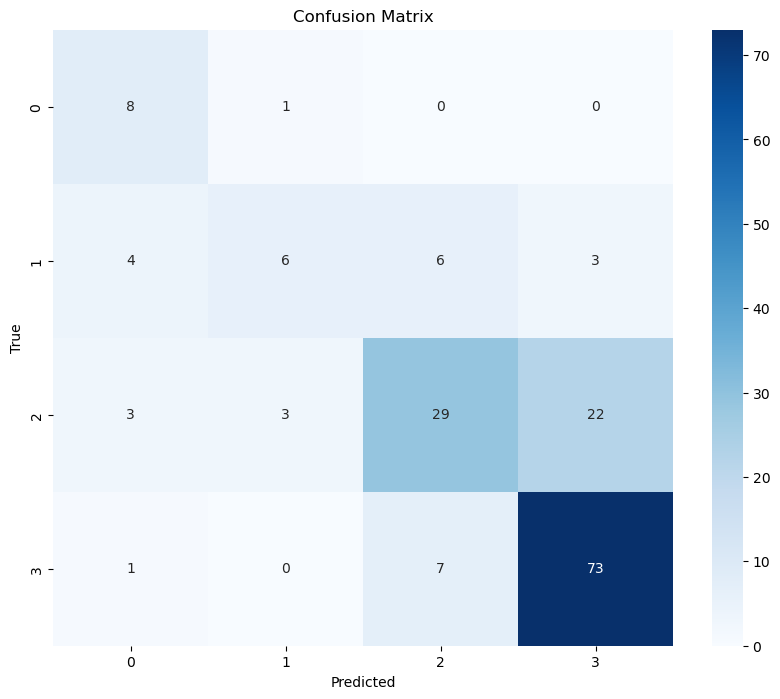

<Figure size 1200x500 with 0 Axes>

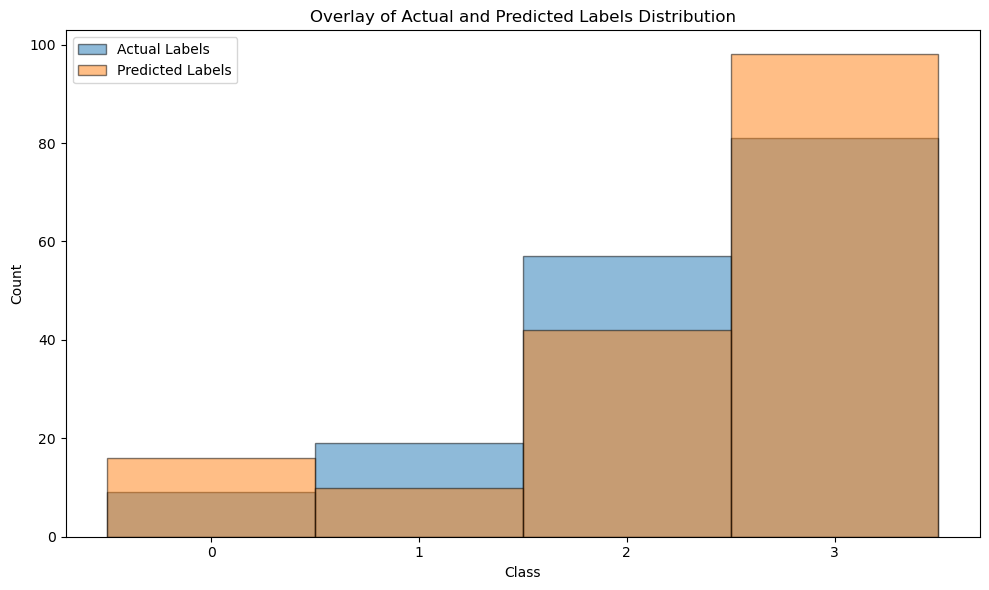

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


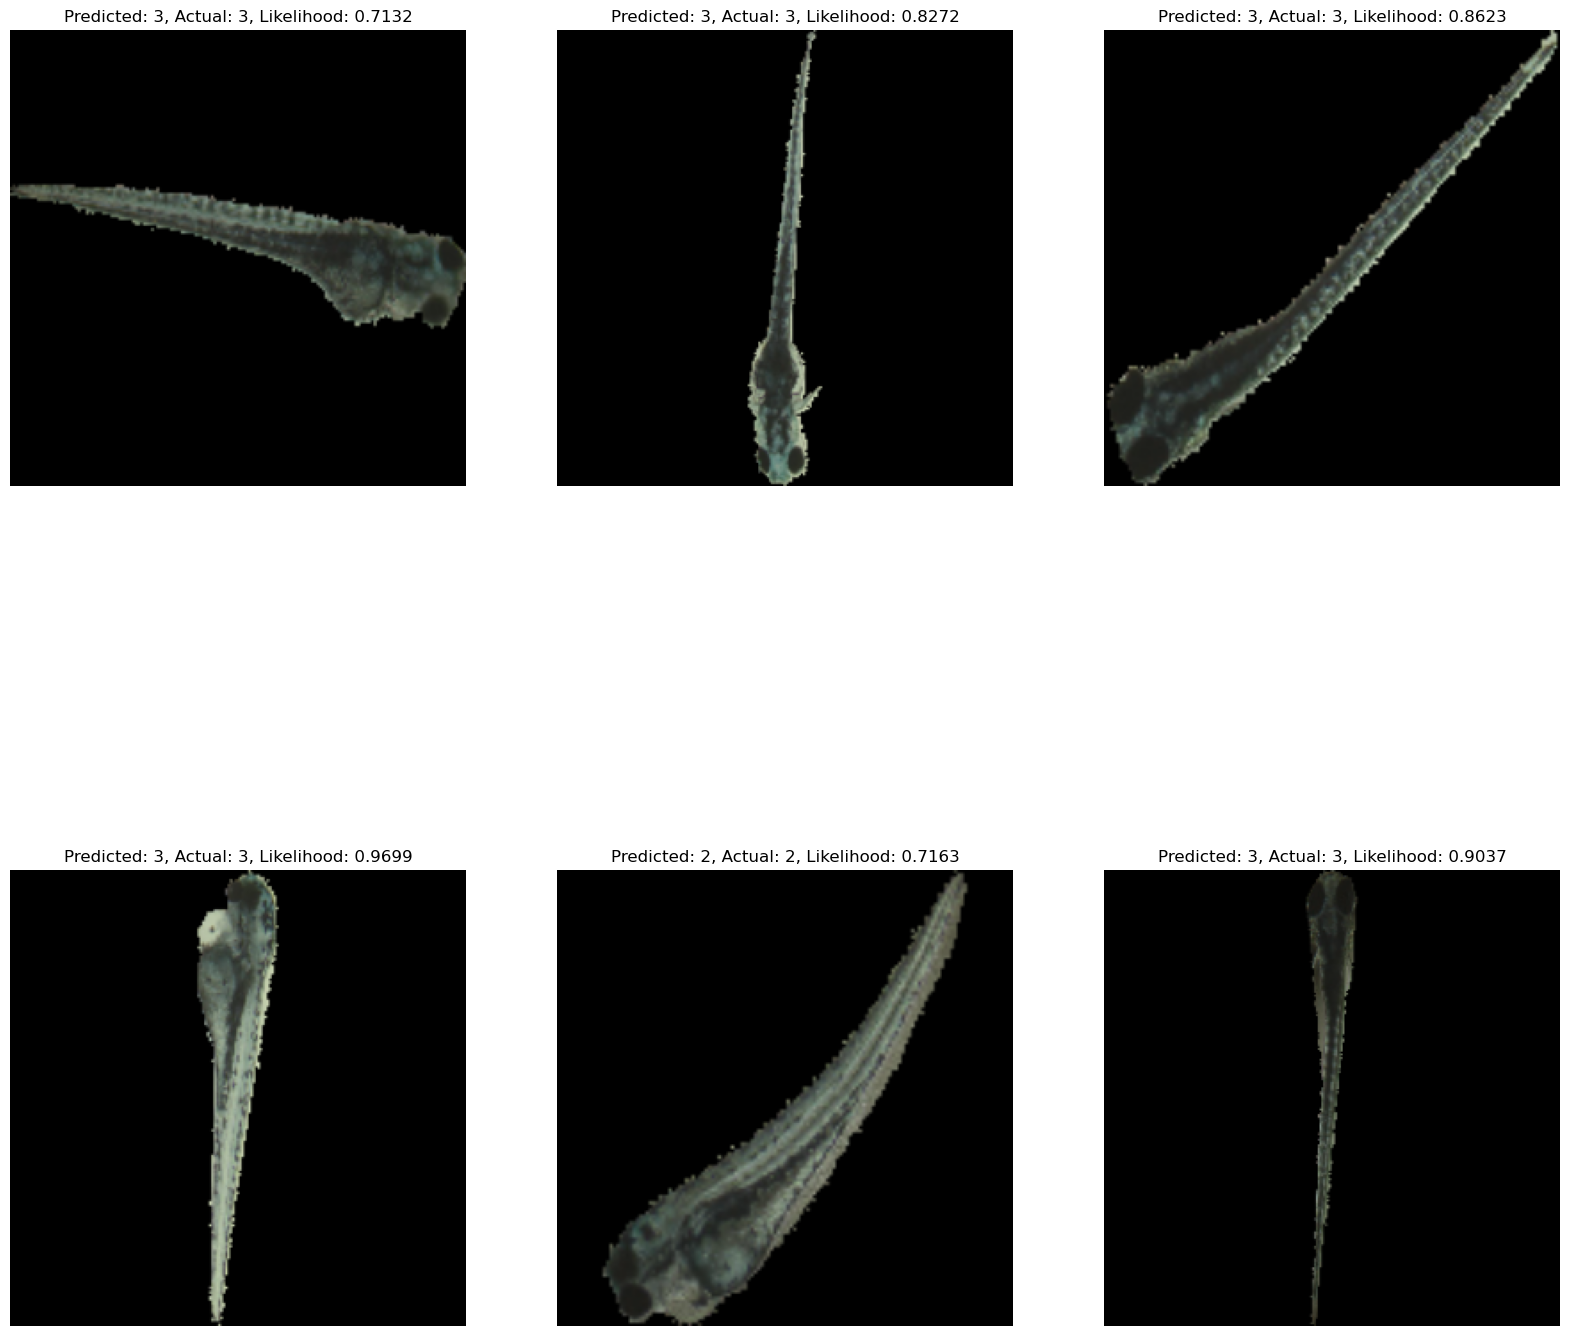

In [145]:
from sklearn.metrics import accuracy_score, f1_score

best_model_path = os.path.join(cnn_log_directory, cnn_model_name)
#best_model_path= f"{load_directory}/{load_model_name}"
model = tf.keras.models.load_model(best_model_path)
    

#8 Display the results
#Add confusion matrix
Skip=False
if Skip:
    # Add training plots from metrics
    plt.figure(figsize=(12, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Get predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Calculate test F1 score
test_f1_score = f1_score(y_test_classes, y_pred_classes, average='weighted')
print(f'Test F1 Score: {test_f1_score:.4f}')

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test_classes)), yticklabels=sorted(set(y_test_classes)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Plot histogram of predicted labels and actual labels
plt.figure(figsize=(12, 5))

# Overlay histograms of actual and predicted labels
plt.figure(figsize=(10, 6))
plt.hist(y_test_classes, bins=np.arange(num_classes + 1) - 0.5, alpha=0.5, label='Actual Labels', edgecolor='black')
plt.hist(y_pred_classes, bins=np.arange(num_classes + 1) - 0.5, alpha=0.5, label='Predicted Labels', edgecolor='black')
plt.xticks(range(num_classes))
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Overlay of Actual and Predicted Labels Distribution')
plt.legend()
plt.tight_layout()
plt.show()
#add test accuracy

model_prediction = y_pred_classes

# Select 5 random indices from the test set
random_indices = random.sample(range(len(X_test)), 6)

images = [X_test_copy[idx] for idx in random_indices]
input_images = [X_test[idx] for idx in random_indices]
#grad_cams = [generate_grad_cam(model, feature_extractor, input_image, target_layer='block5_conv3') for input_image in input_images]
#plot_multiple_grad_cams(images, grad_cams)

fig, axes = plt.subplots(2, 3, figsize=(20, 20))

# Get model predictions and actual labels for the selected images
for i, idx in enumerate(random_indices):
    image = X_test_copy[idx]
    input_image = X_test[idx]
    prediction = model.predict(np.expand_dims(input_image, axis=0))
    predicted_class = np.argmax(prediction)
    actual_class = np.argmax(y_test[idx])
    likelihood = prediction[0][predicted_class]
    
    axes[i//3, i%3].imshow(image / 255.0)
    axes[i//3, i%3].set_title(f"Predicted: {predicted_class}, Actual: {actual_class}, Likelihood: {likelihood:.4f}")
    axes[i//3, i%3].axis('off')
plt.show()

**Expert Analysis**


Expert Analysis
Accuracy with expert analysis: 0.8373
Jensen-Shannon Divergence: 0.1035


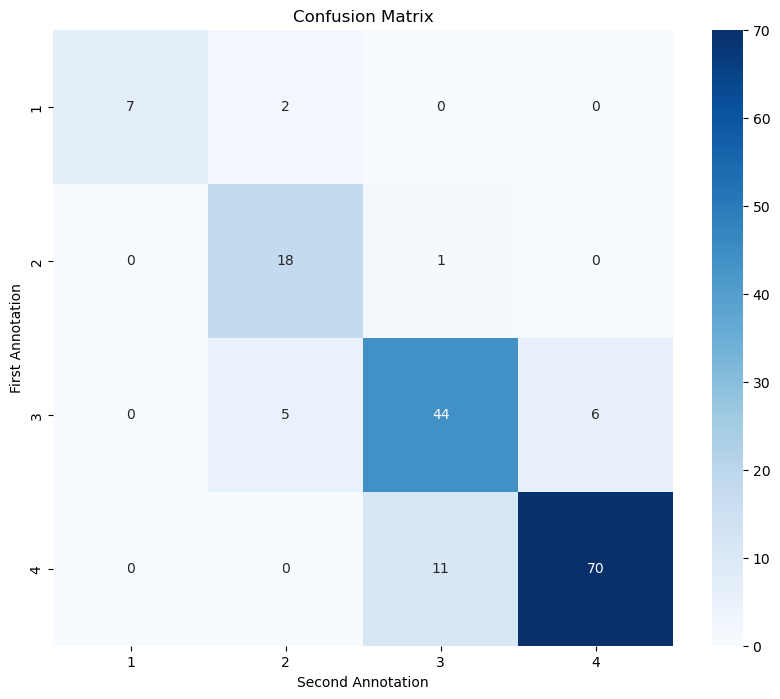

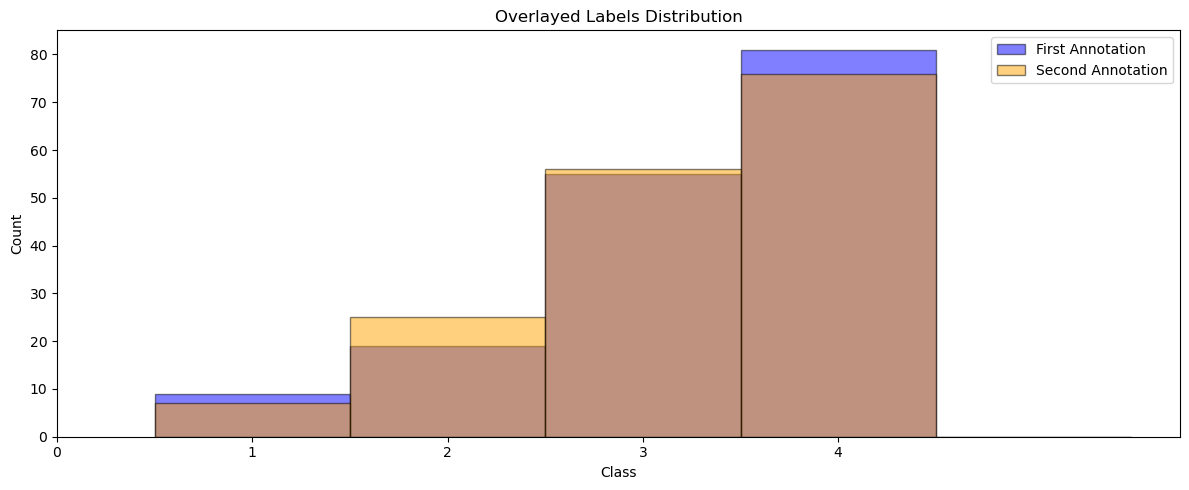

In [146]:
from scipy.spatial.distance import jensenshannon
from collections import Counter

print("Expert Analysis")

# Read the Excel file and extract the column "Curved_2" as y_test_2, skipping rows with NaN
df_excel = pd.read_excel("Expert_Analysis.xlsx")
df_excel = df_excel.dropna(subset=["Curved_2"])  # Drop rows where "Curved_2" is NaN
expert_prediction_2 = df_excel["Curved_2"].astype(int).values
expert_prediction_1 = df_excel["Curved"].astype(int).values 



# Add model predictions to the DataFrame
df_excel["Model_Prediction"] = model_prediction + 1

# Save the updated DataFrame back to the Excel file
df_excel.to_excel("Expert_Analysis.xlsx", index=False)

print(f'Accuracy with expert analysis: {accuracy_score(expert_prediction_1, expert_prediction_2):.4f}')

# Calculate the distributions
dist_class = Counter(expert_prediction_1)
dist_2 = Counter(expert_prediction_2)

# Normalize the distributions to probabilities
total_class = sum(dist_class.values())
total_2 = sum(dist_2.values())

prob_class = [dist_class.get(i, 0) / total_class for i in range(num_classes)]
prob_2 = [dist_2.get(i, 0) / total_2 for i in range(num_classes)]

# Calculate Jensen-Shannon divergence
js_divergence = jensenshannon(prob_class, prob_2)
print(f'Jensen-Shannon Divergence: {js_divergence:.4f}')
expert_prediction_1_nonan = expert_prediction_1[expert_prediction_2 != 0] 
expert_prediction_2_nonan = expert_prediction_2[expert_prediction_2 != 0]

cm = confusion_matrix(expert_prediction_1_nonan, expert_prediction_2_nonan)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(expert_prediction_1_nonan)), yticklabels=sorted(set(expert_prediction_1_nonan)))
plt.xlabel('Second Annotation')
plt.ylabel('First Annotation')
plt.title('Confusion Matrix')
plt.show()
# Plot histogram of predicted labels and actual labels
plt.figure(figsize=(12, 5))

# Overlay histograms of actual and predicted labels

plt.hist(expert_prediction_1_nonan, bins=np.arange(num_classes + 2) + 0.5, alpha=0.5, label='First Annotation', edgecolor='black', color='blue')
plt.hist(expert_prediction_2_nonan, bins=np.arange(num_classes + 2) + 0.5, alpha=0.5, label='Second Annotation', edgecolor='black', color='orange')
plt.xticks(range(num_classes+1))
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Overlayed Labels Distribution')
plt.legend()
plt.tight_layout()
plt.show()


**Distilled Analysis**

Distilled analysis Labels1: 0.7410


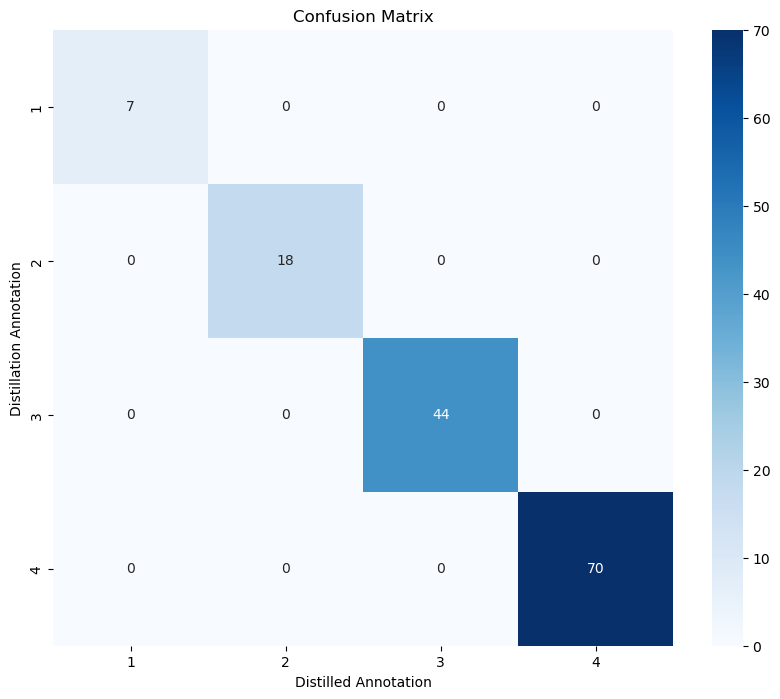

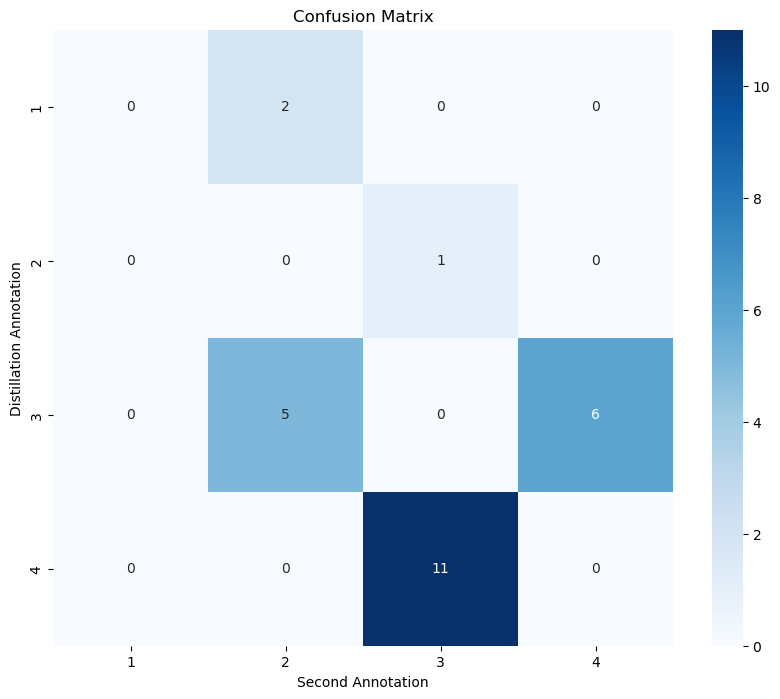

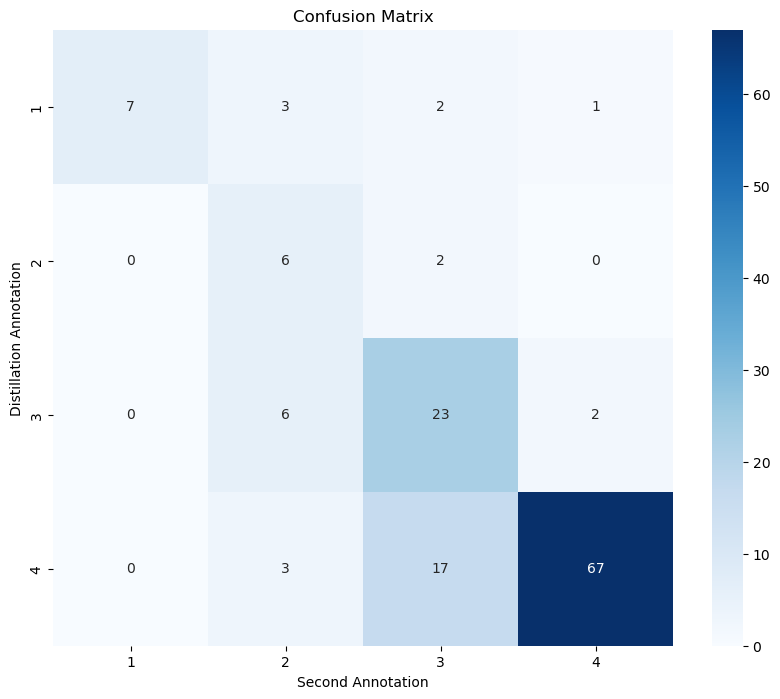

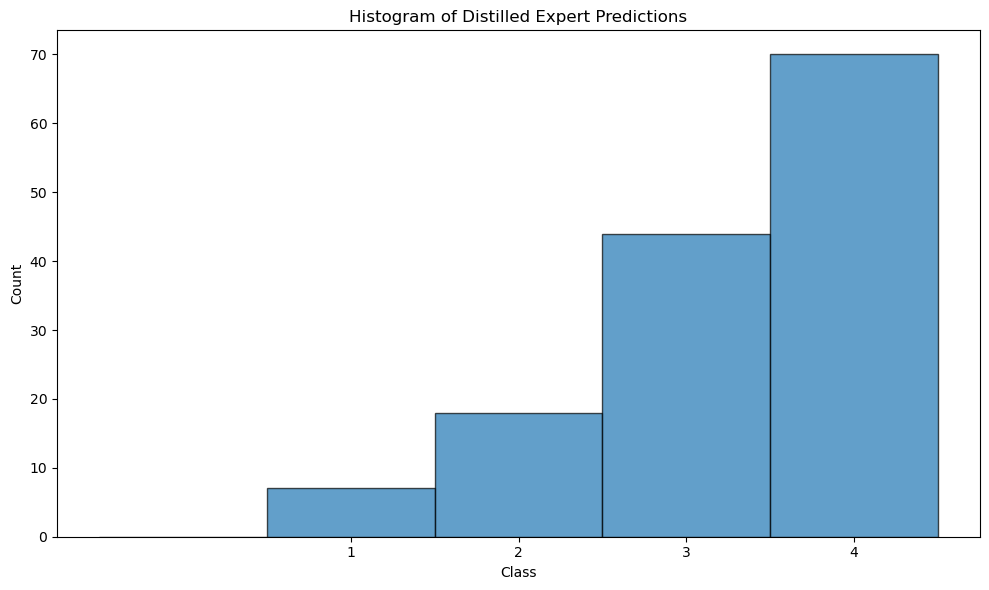

In [147]:
model_prediction_distilled = y_pred_classes[expert_prediction_1==expert_prediction_2] + 1
expert_prediction_distilled = expert_prediction_1[expert_prediction_1==expert_prediction_2]
expert_edge_cases_1 = expert_prediction_1_nonan[expert_prediction_1_nonan!=expert_prediction_2_nonan]
expert_edge_cases_2 = expert_prediction_2_nonan[expert_prediction_1_nonan!=expert_prediction_2_nonan]

print(f'Distilled analysis Labels1: {accuracy_score(model_prediction_distilled, expert_prediction_distilled):.4f}')


cm = confusion_matrix(expert_prediction_distilled, expert_prediction_distilled)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(model_prediction_distilled)), yticklabels=sorted(set(model_prediction_distilled)))
plt.xlabel('Distilled Annotation')
plt.ylabel('Distillation Annotation')
plt.title('Confusion Matrix')
plt.show()

cm = confusion_matrix(expert_edge_cases_1, expert_edge_cases_2)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(model_prediction_distilled)), yticklabels=sorted(set(model_prediction_distilled)))
plt.xlabel('Second Annotation')
plt.ylabel('Distillation Annotation')
plt.title('Confusion Matrix')
plt.show()

cm = confusion_matrix(model_prediction_distilled, expert_prediction_distilled)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(model_prediction_distilled)), yticklabels=sorted(set(model_prediction_distilled)))
plt.xlabel('Second Annotation')
plt.ylabel('Distillation Annotation')
plt.title('Confusion Matrix')
plt.show()

# Plot histogram of distilled expert predictions
plt.figure(figsize=(10, 6))
plt.hist(expert_prediction_distilled, bins=np.arange(num_classes + 2) - 0.5, edgecolor='black', alpha=0.7)
plt.xticks(range(1, num_classes + 1))
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Histogram of Distilled Expert Predictions')
plt.tight_layout()
plt.show()

In [148]:
from sklearn.metrics import accuracy_score, f1_score

best_model_path = os.path.join(cnn_log_directory, 'model0704.keras')
#best_model_path= f"{load_directory}/{load_model_name}"
model = tf.keras.models.load_model(best_model_path)
    

#8 Display the results
#Add confusion matrix
Skip=False
if Skip:
    # Add training plots from metrics
    plt.figure(figsize=(12, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Get predictions for the test set
y_pred = model.predict(X_test)
confidence_threshold = 0.55


y_pred_classes = []
y_test_classes = []

for i, prediction in enumerate(y_pred):
    max_confidence = np.max(prediction)
    if max_confidence >= confidence_threshold:
        y_pred_classes.append(np.argmax(prediction))
        y_test_classes.append(np.argmax(y_test[i]))


y_pred_distilled = y_pred[expert_prediction_1==expert_prediction_2]
y_test_dist = y_test[expert_prediction_1==expert_prediction_2]

y_pred_classes_dist = []
y_test_classes_dist = []

for i, prediction in enumerate(y_pred_distilled):
    max_confidence = np.max(prediction)
    if max_confidence >= confidence_threshold:
        y_pred_classes_dist.append(np.argmax(prediction))
        y_test_classes_dist.append(np.argmax(y_test_dist[i]))
        
# Calculate the number and percentage of filtered-out images
total_images = len(y_pred)
filtered_out_images = total_images - len(y_pred_classes)
filtered_out_percentage = (filtered_out_images / total_images) * 100

print(f"Filtered out images: {filtered_out_images}")
print(f"Percentage of filtered out images: {filtered_out_percentage:.2f}%")

# Calculate test accuracy
test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'Test Accuracy: {test_accuracy:.4f}')

test_accuracy_dist = accuracy_score(y_test_classes_dist, y_pred_classes_dist)
print(f'Test Accuracy (Distilled): {test_accuracy_dist:.4f}')

# Calculate test F1 score
test_f1_score = f1_score(y_test_classes, y_pred_classes, average='weighted')
print(f'Test F1 Score: {test_f1_score:.4f}')

test_f1_score_dist = f1_score(y_test_classes_dist, y_pred_classes_dist, average='weighted')
print(f'Test F1 Score (Distilled): {test_f1_score_dist:.4f}')

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
cm_dist = confusion_matrix(y_test_classes_dist, y_pred_classes_dist)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test_classes)), yticklabels=sorted(set(y_test_classes)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Plot histogram of predicted labels and actual labels
plt.figure(figsize=(12, 5))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_dist, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y_test_classes)), yticklabels=sorted(set(y_test_classes)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Plot histogram of predicted labels and actual labels
plt.figure(figsize=(12, 5))

# Histogram of actual labels
plt.subplot(1, 2, 1)
plt.hist(y_test_classes, bins=np.arange(num_classes + 1) - 0.5, edgecolor='black')
plt.xticks(range(num_classes))
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Actual Labels Distribution')

# Histogram of predicted labels
plt.subplot(1, 2, 2)
plt.hist(y_pred_classes, bins=np.arange(num_classes + 1) - 0.5, edgecolor='black')
plt.xticks(range(num_classes))
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Predicted Labels Distribution')

plt.tight_layout()
plt.show()
#add test accuracy

# Select 5 random indices from the test set
random_indices = random.sample(range(len(X_test)), 6)

images = [X_test_copy[idx] for idx in random_indices]
input_images = [X_test[idx] for idx in random_indices]
#grad_cams = [generate_grad_cam(model, feature_extractor, input_image, target_layer='block5_conv3') for input_image in input_images]
#plot_multiple_grad_cams(images, grad_cams)

fig, axes = plt.subplots(2, 3, figsize=(20, 20))

# Get model predictions and actual labels for the selected images
for i, idx in enumerate(random_indices):
    image = X_test_copy[idx]
    input_image = X_test[idx]
    prediction = model.predict(np.expand_dims(input_image, axis=0))
    predicted_class = np.argmax(prediction)
    actual_class = np.argmax(y_test[idx])
    likelihood = prediction[0][predicted_class]
    
    axes[i//3, i%3].imshow(image / 255.0)
    axes[i//3, i%3].set_title(f"Predicted: {predicted_class}, Actual: {actual_class}, Likelihood: {likelihood:.4f}")
    axes[i//3, i%3].axis('off')
plt.show()

ValueError: File not found: filepath=C:/Local_Docs/Uni/Hiwi_IBT/Zebra_Fish/Models/CNN\model0704.keras. Please ensure the file is an accessible `.keras` zip file.